# Notebook Processo Seletivo Aluno Especial IA-024 1S2024 FEEC-UNICAMP
versão 5 de fevereiro de 2024, 19h


versão 8 de fevereiro de 2024, 20h - ajuste variável vocab_size

Aluno: Marcus Vinícius Borela de Castro

**Observações**:
1. com a indisponibilidade da gpu T4 para mim no google colab após as primeiras execuções, optei por utilizar uma GPU 3090 24 gb a que tenho acesso.
Então, onde se lê T4 no exercício, deve ser considerada uma GPU 3090 24gb

2. como sugerido, utilizamos diálogos com o gpt4 para apoiar nas implementação dos exercícios e nas questões teóricas.

3. optei por codificar o caderno jupyter demonstrando o passo a passo no código do impacto das questões. Separei por legibilidade as perguntas em seções. Assim, no colab, consegue-se acesso direto a partir do índice. E ficou uma documentação viva. Fora que gerar o relatório foi só imprimir como pdf o caderno.


# Importações

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim

In [ ]:
import time
import re
import string
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, Subset


# Caderno Original - execução inicial

## I - Vocabulário e Tokenização

In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
for (label, line) in list(IMDB(split='train')):
    counter.update(line.split())

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)

CPU times: user 8.55 s, sys: 321 ms, total: 8.87 s
Wall time: 1min 9s


In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[8, 35, 0]

## II - Dataset

In [ ]:
%%time
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(label)


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)


CPU times: user 691 ms, sys: 39.8 ms, total: 730 ms
Wall time: 730 ms


## III - Data Loader

In [ ]:
%%time
batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


CPU times: user 332 µs, sys: 30 µs, total: 362 µs
Wall time: 367 µs


In [ ]:
# Iterando sobre as avaliações
for label, text in test_loader:
    print(f"Label: {label}, Texto: {text[:100]}")
    break

Label: tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), Texto: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])


## IV - Modelo

In [ ]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)



## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

**Observação**: com a indisponibilidade do T4 para mim no google colab, utilizei uma GPU 3090 a que tenho acesso.

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: NVIDIA GeForce RTX 3090


In [ ]:
# Model instantiation
model = OneHotMLP(vocab_size)

In [ ]:
%%time

model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

Epoch [1/5],             Loss: 0.6924,             Elapsed Time: 20.38 sec
Epoch [2/5],             Loss: 0.6921,             Elapsed Time: 20.17 sec
Epoch [3/5],             Loss: 0.6854,             Elapsed Time: 19.73 sec
Epoch [4/5],             Loss: 0.6915,             Elapsed Time: 20.00 sec
Epoch [5/5],             Loss: 0.6954,             Elapsed Time: 20.08 sec
CPU times: user 1min 40s, sys: 193 ms, total: 1min 40s
Wall time: 1min 40s


## VI - Avaliação

In [ ]:
%%time
## evaluation
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 55.104%
CPU times: user 19.7 s, sys: 19.9 ms, total: 19.7 s
Wall time: 19.7 s


# Exercícios

## I - Vocabulário e tokenização

### **I.1.** Alguns números

Na célula de calcular o vocabulário, aproveite o laço sobre IMDB de treinamento e utilize um segundo contador para

Calcular o número de amostras positivas e amostras negativas.

Calcule também o comprimento médio do texto em número de palavras dos textos das amostras.

In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
count_positivo = 0
count_negativo = 0
tamanho_total = 0
for (label, line) in list(IMDB(split='train')):
    counter.update(line.split())
    if label == 1:
      count_positivo += 1
    else:
      count_negativo += 1
    # print(f'tamanho: {len(line)} de {line}' )
    tamanho_total += len(line.split())

print(f'Total de amostras: {count_negativo+count_positivo}')
print(f'Amostras positivas: {count_positivo}')
print(f'Amostras negativas: {count_negativo}')
print(f'Tamanho médio do texto: {tamanho_total/(count_negativo+count_positivo)}')

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)
print(f'Tamanho vocabulário: {len(vocab)}')

Total de amostras: 25000
Amostras positivas: 12500
Amostras negativas: 12500
Tamanho médio do texto: 233.7872
Tamanho vocabulário: 20000
CPU times: user 1.33 s, sys: 36.1 ms, total: 1.37 s
Wall time: 1.37 s


### **I.2.** Entendo o tokenizador

As linhas 9 e 10 da célula do vocabulário são linhas típicas de programação python em listas com dicionários com laços na forma compreensão de listas ou list comprehension em inglês. Procure analisar e estudar profundamente o uso de lista e dicionário do python. Estude também a função encode_sentence.

**Enunciado do exercício: **

Mostre as cinco palavras mais frequentes do vocabulário e as cinco palavras menos frequentes.

Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?

Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.


#### **I.2.a** Mostre as cinco palavras mais frequentes do vocabulário e as cinco palavras menos frequentes.

In [ ]:
# Cinco mais e menos frequentes
print(f'Cinco palavras mais frequentes: {counter.most_common(5)}')
print(f'Cinco palavras menos frequentes: {counter.most_common()[:-6:-1]}')

Cinco palavras mais frequentes: [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568)]
Cinco palavras menos frequentes: [('Crocker)', 1), ('McKenzie(Barry', 1), ('shearer', 1), ('grossest', 1), ('unemployed...', 1)]


In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[8, 35, 0]

#### **I.2.b** Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?

R.:*0 (Out Of Vocabulary): assumido no comando get se word não estiver no vocab*

#### **I.2.c** Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.

In [ ]:
def count_unknown_tokens(vocab, list_word):
  """
      Imprime o número de tokens distintas presentes em list_word desconhecidas no vocab
      e o número total de ocorrências delas
  """
  unknown_tokens = set()  # Conjunto para armazenar palavras desconhecidas
  total_occurrences = 0  # Contador para o número total de ocorrências

  for word in list_word:
      if word not in vocab:
        unknown_tokens.add(word)  # Adiciona a palavra desconhecida ao conjunto
        total_occurrences += 1  # Incrementa o contador
      #elif word in unknown_tokens:
      #  total_occurrences += 1  # Incrementa o contador

  print(f"Número de tokens desconhecidas: {len(unknown_tokens)}")
  print(f"Número total de ocorrências de tokens desconhecidas: {total_occurrences}")


In [ ]:
# Exemplo de uso:
list_word_teste = ["maçã", "banana", "laranja", "uva", "abacaxi", "pera", "kiwi", "pêssego", "kiwi", 'pera']
vocab_teste = {"maçã": 1, "banana": 2, "laranja": 3, "uva": 4, "abacaxi": 5}

count_unknown_tokens(vocab_teste, list_word_teste)

Número de tokens desconhecidas: 3
Número total de ocorrências de tokens desconhecidas: 5


In [ ]:
list_treino = list(IMDB(split='train'))

In [ ]:
list_treino[:2]

[(1,
  'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betw

In [ ]:
list_word_treino = []
for target, texto in list_treino:
  # print(texto)
  list_word_treino.extend(texto.split())


In [ ]:
list_word_treino[:5]

['I', 'rented', 'I', 'AM', 'CURIOUS-YELLOW']

In [ ]:
count_unknown_tokens(vocab, list_word_treino)

Número de tokens desconhecidas: 260617
Número total de ocorrências de tokens desconhecidas: 566141


### **I3** Reduzindo o número de amostras para 200

Uma forma simples de reduzir o número de amostras é utilizar o fatiamento de listas para selecionar apenas as primeiras 200 amostras utilizando [:200] na lista do IMDB: list(IMDB(split='train'))[:200].
Faça isto, tanto na linha 5 da célula de calcular o vocabulário como na linha 5 da célula do "II - Dataset".
Com estas duas modificações, execute o notebook por completo novamente. Você verá que o tempo de processamento cairá drasticamente, para aproximadamente 1 a 2 segundos por época. Porém você vai notar que a Acurácia calculada na célula VI - Avaliação sobe para 100% ou próximo disso.
Consegue justificar a razão deste resultado inesperado, entendendo que no treinamento, as perdas em cada época continuam próximas de valores com todo o dataset?
Para ver a resposta, verifique agora no dataset com 200 amostras, quantas são as amostras positivas e quantas são as amostras negativas no dataset de teste.


In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
count_positivo = 0
count_negativo = 0
tamanho_total = 0
for (label, line) in list(IMDB(split='train'))[:200]:
    counter.update(line.split())
    if label == 1:
      count_positivo += 1
    else:
      count_negativo += 1
    # print(f'tamanho: {len(line)} de {line}' )
    tamanho_total += len(line.split())

print(f'Total de amostras: {count_negativo+count_positivo}')
print(f'Amostras positivas: {count_positivo}')
print(f'Amostras negativas: {count_negativo}')
print(f'Tamanho médio do texto: {tamanho_total/(count_negativo+count_positivo)}')

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab_lim_200 = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size_lim_200 = len(vocab_lim_200)
print(f'Tamanho vocabulário limitado 200: {len(vocab_lim_200)}')

Total de amostras: 200
Amostras positivas: 200
Amostras negativas: 0
Tamanho médio do texto: 225.85
Tamanho vocabulário limitado 200: 10118
CPU times: user 383 ms, sys: 12 ms, total: 395 ms
Wall time: 394 ms


In [ ]:
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))[:200]
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(label)


# Load Data with One-hot Encoding
train_data_lim_200 = IMDBDataset('train', vocab_lim_200)
test_data_lim_200 = IMDBDataset('test', vocab_lim_200)


In [ ]:
%%time
batch_size = 128
# define dataloaders
train_loader_lim_200 = DataLoader(train_data_lim_200, batch_size=batch_size, shuffle=True)
test_loader_lim_200 = DataLoader(test_data_lim_200, batch_size=batch_size, shuffle=False)


CPU times: user 261 µs, sys: 4 µs, total: 265 µs
Wall time: 268 µs


In [ ]:
print(f'Número de registros no dataset de treino: {len(train_loader_lim_200.dataset)}')
print(f'Número de registros no dataset de teste: {len(test_loader_lim_200.dataset)}')

Número de registros no dataset de treino: 200
Número de registros no dataset de teste: 200


In [ ]:
for data in next(iter(train_loader_lim_200)):
  print(type(data))
  print(data)
  #break
"""
    if isinstance(data, tuple) and len(data) == 2:
        inputs, labels = data  # Desempacota os dados
        # Imprime os dados (inputs) e os rótulos (labels)
        print("Dados (inputs):")
        print(inputs)

        print("\nRótulos (labels):")
        print(labels)
    else:
        print("Estrutura de dados inesperada. Verifique o formato do objeto 'data'.")
"""

<class 'torch.Tensor'>
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]])
<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


'\n    if isinstance(data, tuple) and len(data) == 2:\n        inputs, labels = data  # Desempacota os dados\n        # Imprime os dados (inputs) e os rótulos (labels)\n        print("Dados (inputs):")\n        print(inputs)\n\n        print("\nRótulos (labels):")\n        print(labels)\n    else:\n        print("Estrutura de dados inesperada. Verifique o formato do objeto \'data\'.")\n'

In [ ]:
del model

In [ ]:
# Model instantiation
model_lim_200 = OneHotMLP(vocab_size_lim_200)

In [ ]:
%%time
model_lim_200 = model_lim_200.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_lim_200.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model_lim_200.train()
    for inputs, labels in train_loader_lim_200:
        print(labels[0])
        print(inputs[0])
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model_lim_200(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Epoch [1/5],             Loss: 0.6718,             Elapsed Time: 0.19 sec
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Epoch [2/5],             Loss: 0.6707,             Elapsed Time: 0.15 sec
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Epoch [3/5],             Loss: 0.6694,             Elapsed Time: 0.15 sec
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Epoch [4/5],             Loss: 0.6656,             Elapsed Time: 0.16 sec
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
tensor(1)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Epoch [5/5],             Loss: 0.6656,             Elapsed Time: 0.15 sec
CPU times: user 775 ms, sys: 32 ms, total: 807 ms
Wall time: 806 ms


In [ ]:
%%time
## evaluation
model_lim_200.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader_lim_200:
        print(f' Labels: {labels[:10]}')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_lim_200(inputs)
        print(f'Outputs {outputs[:10]}')
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        print(f'Predicted {predicted[:10]}')
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')

 Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Outputs tensor([[0.0474],
        [0.0446],
        [0.0451],
        [0.0119],
        [0.0381],
        [0.0663],
        [0.0773],
        [0.0578],
        [0.0571],
        [0.0649]], device='cuda:0')
Predicted tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
 Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Outputs tensor([[0.0533],
        [0.0315],
        [0.0833],
        [0.1085],
        [0.0474],
        [0.0586],
        [0.0791],
        [0.0546],
        [0.0657],
        [0.0540]], device='cuda:0')
Predicted tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Test Accuracy: 100.0%
CPU times: user 165 ms, sys: 16 ms, total: 181 ms
Wall time: 180 ms


#### **I.3.a)** Qual é a razão pela qual o modelo preditivo conseguiu acertar 100% das amostras de teste do dataset selecionado com apenas as primeiras 200 amostras?


R.: porque os 200 primeiros registros de treinamento são todos positivos. E os primeiros 200 dados de teste também. Daí o modelo aprendeu a prever positivo. E os testes apenas testaram se era positivo.

#### **I.3.b)** Modifique a forma de selecionar 200 amostras do dataset, porém garantindo que ele continue balanceado, isto é, aproximadamente 100 amostras positivas e 100 amostras negativas.


In [ ]:
class IMDBDatasetBalanced(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

        # Separa os exemplos 100 por classe
        positive_examples = [item for item in self.data if item[0] == 1][:100]
        negative_examples = [item for item in self.data if item[0] != 1][:100]

        print('negative')
        for label, input in negative_examples:
            print(label)
            break

        print('positive')
        for label, input in positive_examples:
            print(label)
            break

        # Combina os exemplos das duas classes
        self.data = positive_examples + negative_examples

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(label)
train_data_lim_200_balanced = IMDBDatasetBalanced('train', vocab_lim_200)
test_data_lim_200_balanced = IMDBDatasetBalanced('test', vocab_lim_200)

negative
2
positive
1
negative
2
positive
1


In [ ]:
for input, label in train_data_lim_200_balanced:
    print(label)
    break

tensor(1)


Conferindo se está balanceado:

In [ ]:
# Crie um defaultdict com valor padrão 0 para contagem das classes
label_counts = {}

for _, label in train_data_lim_200_balanced:
    if label.item() not in label_counts:
        label_counts[label.item()] = 0
    label_counts[label.item()] += 1

# Imprime o total por valor em label
for value, count in label_counts.items():
    print(f"Label {value}: {count} exemplos")

Label 1: 100 exemplos
Label 0: 100 exemplos


Se o pedido fosse para balancear o dataload, teria partido para algo parecido com o comando abaixo (não executado):


        from torch.utils.data import WeightedRandomSampler

        # Calcule os pesos para cada classe
        class_counts = [100, 100]  # Número de exemplos para cada classe
        weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

        # Crie um sampler ponderado
        sampler = WeightedRandomSampler(weights, len(train_data), replacement=True)

        # Crie o DataLoader com o sampler
        train_loader_balanced = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

## **II - Dataset**

Precisamos entender como funciona a classe IMDBDataset. Ela é a classe responsável para acessar cada amostra do dataset.

Em primeiro lugar precisamos entender qual será a entrada da rede neural para decidir se o texto é uma crítica positiva ou negativa. Uma das formas mais simples de construir um modelo preditivo é com base nas palavras utilizadas no texto. A distribuição das palavras de um texto tem alta correlação com o fato do texto estar falando bem ou falando mal de um filme. Certamente é estimativa que possui seus erros, mas é a forma mais simples e eficiente de se fazer uma análise de sentimento ou de maneira geral uma classificação de um texto. Esse método é denominado "Bag of Words". A entrada da rede neural, para cada amostra, será um vetor de comprimento do vocabulário, com valores todos zero, com exceção dos tokens que aparecem no texto da amostra. Esse método de codificação é também denominado "One-Hot". Estude o código da classe IMDBDataset fazendo experimentos e perguntas ao chatGPT para entender com profundidade esta classe.


Enunciado do exercício:


### **II.1** Investigação inicial

#### II.1.a) Investigue o dataset criado na linha 24. Faça um código que aplique um laço sobre o dataset train_data e calcule novamente quantas amostras positivas e negativas do dataset.


In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
for (label, line) in list(IMDB(split='train')):
    counter.update(line.split())

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)

CPU times: user 1.1 s, sys: 36 ms, total: 1.14 s
Wall time: 1.14 s


In [ ]:
%%time
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(label)


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)


CPU times: user 678 ms, sys: 36.1 ms, total: 714 ms
Wall time: 713 ms


In [ ]:
# Crie um defaultdict com valor padrão 0 para contagem das classes
label_counts = {}

for _, label in train_data:
    if label.item() not in label_counts:
        label_counts[label.item()] = 0
    label_counts[label.item()] += 1

# Imprime o total por valor em label
for value, count in label_counts.items():
    print(f"Label {value}: {count} exemplos")

Label 1: 12500 exemplos
Label 0: 12500 exemplos


#### II.1.b) Calcule também o número médio de palavras codificadas em cada vetor one-hot. Compare este valor com o comprimento médio de cada texto (contado em palavras), conforme calculado no exercício I.1.c. e explique a diferença.


In [ ]:
len(train_data)

25000

In [ ]:
total_palavras = 0
for input, _ in train_data:
    # print(input)
    # print(torch.sum(input).item())
    total_palavras += torch.sum(input).item()
print(f'A média de palavras em cada vertor é {total_palavras/len(train_data)}')

A média de palavras em cada vertor é 133.09548


Em I.1.c o tamanho médio era 233.78 palavras por sentença.
O valor menor 133.09 é explicado por dois motivos:
1. A não contagem de repetições (trata-se de um bag of words binário, com valores 0 ou 1 conforme o token esteja na sentença, e não com quantidade de ocorrências do token, seria uma versão "count").
2. Como o vocabulário só tem 20000 tokens diferentes, uma grande parte de tokens distintas (260617, conforme exercício I.2.C) não foram contadas. Na realidade todas elas foram consideradas como uma única token (out of vocabulary) na posição 0 do tensor.

A rede neural será alimentada pelo vetor one-hot (quais suas dimensões) e fará uma predição da probabilidade do texto associado ao one-hot ser uma mensagem positiva.

### **II.2** Aumentando a eficiência do treinamento com o uso da GPU T4



O código do notebook está preparado para executar tanto com ambiente usando CPU como com GPU, entretanto o ganho de velocidade está sendo reduzido de 45 segundos para 29 segundos que é um ganho muito aquém do esperado que seria ter um speedup entre 7 e 11 vezes dependendo da aplicação. Vamos entender a razão desta baixa eficiência e corrigir o problema.

A GPU é utilizada durante o treinamento do modelo, onde é utilizada a técnica de minimização da Loss utilizando o gradiente descendente. Isso ocorre na segunda célula do "V - Laço de Treinamento". Iremos analisar os detalhes mais à frente, para por enquanto basta entender onde a GPU é utilizada. A linha 17 é onde o modelo está fazendo a predição (passo forward), dado a entrada, calcula a saída da rede (muitas vezes chamado de logito) e o cálculo da loss está sendo feito na linha seguinte e o cálculo do gradiente ocorre na linha 21 e a linha 22 é onde ocorre o ajuste dos parâmetros (weights) da rede neural fazendo ela minimizar a Loss. Esse é o processo que é mais demorado e onde a GPU tem muitos ganhos, pois envolve praticamente apenas multiplicação de matrizes. Existem apenas 3 linhas que controlam o uso da GPU que servem para colocar o modelo, a entrada e a saída esperada (labels) na GPU: linhas 3, 14 e 15, respectivamente.

Enunciado do exercício: Com a o notebook configurado para GPU T4, meça o tempo de dois laços dentro do for da linha 13 (coloque um break após dois laços) e determine quanto demora demora para o passo de forward (linhas 14 a 18), para o backward (linhas 20, 21 e 22) e o tempo total de um laço. Faça as contas e identifique o trecho que é mais demorado.



**Observação**: com a indisponibilidade do T4 para mim no google colab, utilizei uma GPU 3090 a que tenho acesso.

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: NVIDIA GeForce RTX 3090


#### **II.2.a)** Tempo do laço = ; Tempo do forward = ;Tempo do backward = ; Conclusão.


In [ ]:
%%time
batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


CPU times: user 7.79 ms, sys: 0 ns, total: 7.79 ms
Wall time: 7.76 ms


In [ ]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)



In [ ]:
# Model instantiation
model = OneHotMLP(vocab_size)

In [ ]:
%%time

model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    tempo_forward = 0
    tempo_backward = 0
    tempo_move_gpu = 0

    for cnt, (inputs, labels) in enumerate(train_loader):
        if cnt >= 2:
            break
        print(f"Batch {cnt+1}")
        # mover para gpu
        move_gpu_begin_time =  time.time()
        inputs = inputs.to(device)
        labels = labels.to(device)
        tempo_move_gpu += time.time() - move_gpu_begin_time
        # Forward pass
        forward_begin_time =  time.time()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        tempo_forward += time.time() - forward_begin_time
        # Backward and optimize
        backward_begin_time =  time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tempo_backward += time.time() - backward_begin_time

    tempo_total = time.time() - start_time


    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')
    break
print(f'Tempo total = {round(tempo_total,3)}')
print(f'Tempo move tensor to gpu = {round(tempo_move_gpu,5)} {round(tempo_move_gpu/tempo_total,6)}%')
print(f'Tempo forward = {round(tempo_forward,5)} {round(tempo_forward/tempo_total,6)}%')
print(f'Tempo backward = {round(tempo_backward,5)} {round(tempo_backward/tempo_total,6)}%')


Batch 1
Batch 2
Epoch [1/5],             Loss: 0.6946,             Elapsed Time: 0.32 sec
Tempo total = 0.321
Tempo move tensor to gpu = 0.02407 0.074982%
Tempo forward = 0.00111 0.003464%
Tempo backward = 0.0014 0.004352%
CPU times: user 498 ms, sys: 20.1 ms, total: 518 ms
Wall time: 322 ms


**R.:** (soma dos 2 laços)

Tempo total=0.321; Tempo de movimentação para gpu = 0.02 (7%); Tempo do forward = 0.0011 (3%); Tempo do backward = 0.0014 (4%);

Conclusão

O tempo de percorrimento do dataloader é o maior gargalo, aproximadamente 86%.


#### **II.2.b)** Trecho que precisa ser otimizado. (Esse é um problema mais difícil)


R.: Esse loop precisa ser otimizado! (ver mais detalhes na solução que se segue em II.2.c.)

In [ ]:
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    (...)
    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(label)


#### **II.2.c)** Otimize o código e explique aqui.



Após esta otimização, é esperado que o tempo de processamento de cada época caia tanto para execução em CPU (da ordem de 10 segundos por época) como para GPU (da ordem de 1 a 2 segundos por época). Isso utilizando as 25 mil amostras do dataset IMDB inteiro.

Agora que a execução está bem mais otimizada em tempos de execução, mantenha o dataset completo: 25 mil amostras e vamos analisar um outro fator importante que é a escolha do LR (Learning Rate)



R.: Primeiro troquei o encode_sentence por return_vocab_in_sentence que não passa mais de uma vez em repetições de uma palavra (usado set).

In [ ]:
def return_vocab_in_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in set(sentence.split())] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[35, 0, 8]

Depois, retirado loop

        for word in encode_sentence(line, self.vocab):
            X[word] = 1

para

        X[encode_sentence(line, self.vocab) vocab)] = 1

E, por fim, como o conjunto de dados não é muito grande, optei por carregar os tensores no __init__

Em contrapartida, haverá economia de memória ao não mais armazenar os textos (self.data). Segue código otimizado.

Obs.: fora do escopo deste exercício a avaliação se haverá ou não economia de memória nessa troca. Mas, de tempo, com certeza (cache de valores calculados).

In [ ]:
%%time
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        data = list(IMDB(split=split))
        self.vocab = vocab
        self.labels = [torch.tensor(1) if item[0] == 1 else torch.tensor(0) for item in data]

        self.sentences = []
        for label, line in data:
            X = torch.zeros(len(self.vocab) + 1)
            X[return_vocab_in_sentence(line, self.vocab)] = 1
            self.sentences.append(X)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # print('retornando idx', idx, self.sentences[idx], self.labels[idx])
        return self.sentences[idx], self.labels[idx]


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

CPU times: user 4.33 s, sys: 92.1 ms, total: 4.43 s
Wall time: 4.42 s


In [ ]:
%%time
batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


CPU times: user 53.8 ms, sys: 0 ns, total: 53.8 ms
Wall time: 53.6 ms


In [ ]:
%%time

model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    tempo_forward = 0
    tempo_backward = 0
    tempo_move_gpu = 0

    for cnt, (inputs, labels) in enumerate(train_loader):
        if cnt >= 2:
            break
        print(f"Batch {cnt+1}")
        # mover para gpu
        move_gpu_begin_time =  time.time()
        inputs = inputs.to(device)
        labels = labels.to(device)
        tempo_move_gpu += time.time() - move_gpu_begin_time
        # Forward pass
        forward_begin_time =  time.time()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        tempo_forward += time.time() - forward_begin_time
        # Backward and optimize
        backward_begin_time =  time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tempo_backward += time.time() - backward_begin_time

    tempo_total = time.time() - start_time


    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')
    break
print(f'Tempo total = {round(tempo_total,3)}')
print(f'Tempo move tensor to gpu = {round(tempo_move_gpu,5)} {round(tempo_move_gpu/tempo_total,6)}%')
print(f'Tempo forward = {round(tempo_forward,5)} {round(tempo_forward/tempo_total,6)}%')
print(f'Tempo backward = {round(tempo_backward,5)} {round(tempo_backward/tempo_total,6)}%')


Batch 1
Batch 2
Epoch [1/5],             Loss: 0.6939,             Elapsed Time: 0.03 sec
Tempo total = 0.034
Tempo move tensor to gpu = 0.02415 0.703817%
Tempo forward = 0.00087 0.025221%
Tempo backward = 0.00158 0.046106%
CPU times: user 19.1 ms, sys: 16.1 ms, total: 35.2 ms
Wall time: 34.9 ms


Tempo total nos 2 laços caiu de 0.321 para 0.034, para cerca de 10%.

Tempo finais (apenas para comparativo dentro do loop):
 Movimentação para gpu = 0.02 (70%); Tempo do forward = 0.0008 (2.5%); Tempo do backward = 0.0015 (4,6%); Percorrimento dataloader: 22,9%


### **II.3** Escolhendo um bom valor de LR

Enunciado do exercício: Faça a melhor escolha do LR, analisando o valor da acurácia no conjunto de teste, utilizando para cada valor de LR, a acurácia obtida. Faça um gráfico de Acurácia vs LR e escolha o LR que forneça a maior acurácia possível.


Ações prévias

Definindo lista de valores de LR

Melhor usar versão de logspace que gera num_values valores igualmente espaçados em uma escala logarítmica entre 10^min_lr e 10^max_lr.

In [ ]:
num_values = 8
# Define the minimum and maximum learning rate and the number of values
min_lr = 0.000001
max_lr = 0.1
learning_rates_list = np.linspace(min_lr, max_lr, num=num_values)
print('linespace', learning_rates_list)

# Generate the learning rates
min_lr = -8  # 10^-4
max_lr = -1  # 10^-1

learning_rates_list = np.logspace(min_lr, max_lr, num=num_values)
print('logspace', learning_rates_list)
# Now learning_rates is an array with 20 values equally spaced between 0.0001 and 0.1

linespace [1.00000000e-06 1.42865714e-02 2.85721429e-02 4.28577143e-02
 5.71432857e-02 7.14288571e-02 8.57144286e-02 1.00000000e-01]
logspace [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]


Criando funções de treino e avaliação para chamar no loop de para cada learning rate

In [ ]:
def evaluate(model, test_loader):
    ## evaluation
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total

        return test_accuracy

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, verbose:bool=True):

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start time of the epoch
        model.train()
        for cnt_batch, (inputs, labels) in enumerate(train_loader):


            # print(f"Batch {cnt+1}")
            # mover para gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            if verbose and cnt_batch==0:
                # Verifique as dimensões dos tensores
                print("Dimensões dos outputs:", outputs.shape)
                print("Dimensões dos labels:", labels.shape)
            loss = criterion(outputs.squeeze(), labels.float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - epoch_start_time  # Duration of epoch

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], \
                    Loss: {loss.item():.4f}, \
                    Elapsed Time: {epoch_duration:.2f} sec')

    # Evaluate the model and record the test accuracy
    test_accuracy = evaluate(model, test_loader)

    return test_accuracy



#### **II.3.a)** Gráfico Acurácia vs LR


Efetuando o treinamento

In [ ]:
train_loader = DataLoader(train_data,
                          batch_size= batch_size,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

In [ ]:
print(f"train_loader tem {len(train_loader)} batches")

train_loader tem 196 batches


In [ ]:
# Initialize a dictionary to record test accuracy for each learning rate
test_accuracies_by_lr = {}

for cnt_treino, lr in enumerate(learning_rates_list):
    # Model instantiation
    model = OneHotMLP(vocab_size)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_start_time = time.time()  # Start time of the epoch
    test_accuracy = train_model(model, criterion, optimizer, num_epochs=5, train_loader, test_loader)

    train_duration = time.time() - train_start_time  # Duration of epoch

    test_accuracies_by_lr[lr] = test_accuracy
    print(f'Treino [{cnt_treino + 1}/{len(learning_rates_list)}]: lr={lr}; test_accuracy={round(test_accuracy,4)}  (train_duration {train_duration:.2f} sec)')

Epoch [1/5],                 Loss: 0.6950,                 Elapsed Time: 1.53 sec
Epoch [2/5],                 Loss: 0.6937,                 Elapsed Time: 1.57 sec
Epoch [3/5],                 Loss: 0.6930,                 Elapsed Time: 1.51 sec
Epoch [4/5],                 Loss: 0.6922,                 Elapsed Time: 1.57 sec
Epoch [5/5],                 Loss: 0.6960,                 Elapsed Time: 1.58 sec
Treino [1/8]: lr=1e-08; test_accuracy=47.972  (train_duration 8.88 sec)
Epoch [1/5],                 Loss: 0.6902,                 Elapsed Time: 1.50 sec
Epoch [2/5],                 Loss: 0.6940,                 Elapsed Time: 1.53 sec
Epoch [3/5],                 Loss: 0.6904,                 Elapsed Time: 1.53 sec
Epoch [4/5],                 Loss: 0.6970,                 Elapsed Time: 1.58 sec
Epoch [5/5],                 Loss: 0.6929,                 Elapsed Time: 1.56 sec
Treino [2/8]: lr=1e-07; test_accuracy=50.336  (train_duration 8.83 sec)
Epoch [1/5],                 Loss: 0

Gerando o gráfico

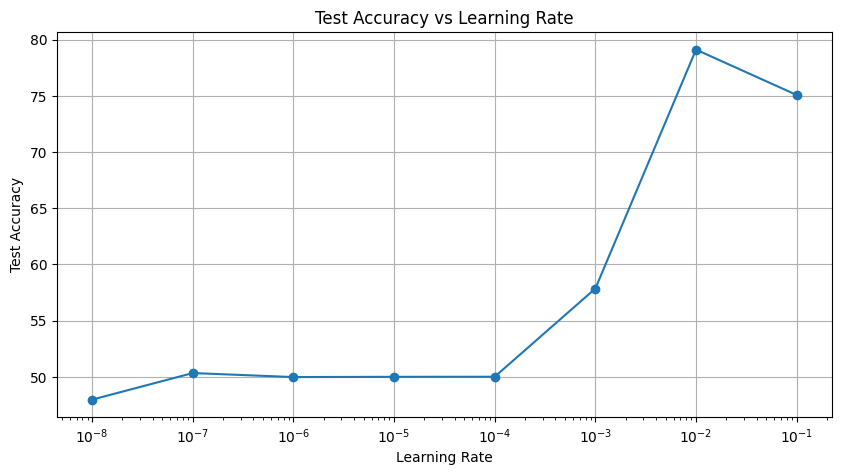

In [ ]:

# Plot test accuracy for each learning rate
plt.figure(figsize=(10, 5))
plt.plot(list(test_accuracies_by_lr.keys()), list(test_accuracies_by_lr.values()), marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')
plt.grid(True)
plt.show()


#### **II.3.b)** Valor ótimo do LR


R.: Segue resposta

Obs.: treinamentos diferentes retornaram LR diferentes como melhores. Não é escopo deste exercício tratar a repetibilidade dos resultados.

In [ ]:
best_lr = max(test_accuracies_by_lr, key=test_accuracies_by_lr.get)
print(f'The learning rate with the highest test accuracy is {best_lr}')

The learning rate with the highest test accuracy is 0.01


#### **II.3.c)** Mostre a equação utilizada no gradiente descendente e qual é o papel do LR no ajuste dos parâmetros (weights) do modelo da rede neural.



R.:

$$
\theta=\theta-\eta\cdot\nabla_{\theta}J(\theta)\
$$

Nesta equação:

$ (\theta) $ - são os parâmetros (ou pesos) do modelo

$(\eta)$ é a taxa de aprendizado (LR).

$ (\nabla_{\theta} J(\theta)) $ é o gradiente da função de perda J com relação aos parâmetros $(\theta)$.



O papel do LR no ajuste dos parâmetros do modelo da rede neural é determinar o tamanho do passo em cada iteração do gradiente descendente. Um LR alto pode fazer com que o algoritmo de otimização dê passos maiores e possivelmente pule o mínimo global. Por outro lado, um LR muito baixo pode fazer com que o algoritmo de otimização dê passos muito pequenos, o que pode resultar em um tempo de treinamento muito longo ou o algoritmo pode ficar preso em um mínimo local. Portanto, a escolha do LR é um compromisso entre a velocidade de treinamento e a capacidade do modelo de encontrar o mínimo global da função de perda.

### **II.4** Otimizando o tokenizador



Agora que a convergência da Loss está melhor, vamos experimentar os parâmetros do tokenizador, isto é, como as palavras estão codificadas em tokens.
Observe novamente o vocab criado na parte I - Vocabulário e Tokenização. Perceba como as pontuações estão influenciando nos tokens criados e como o uso de letras maiúsculas e minúsculas também podem atrapalhar a consistência dos tokenizador em representar o significado semântico das palavras. Experimente rodar o encode_sentence com frases que tenham pontuações e letras maiúsculas e minúsculas. Baseado nessas informações, procure melhorar a forma de tokenizar o dataset.
Enunciado do exercício: Melhores a forma de tokenizar, isto é, pré-processar o dataset de modo que a codificação seja indiferente das palavras serem escritas com maiúsculas ou minúsculas e sejam pouco influenciadas pelas pontuações.


Identificando o problema

In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[8, 35, 0]

In [ ]:
for sentence in ["I like Pizza", "I like pizza", "I Like pizza", "I like Pizza.", "I like Pizza .", "I like, Pizza", ]:
    coded_sentence = encode_sentence(sentence, vocab)
    print(f'Para sentença {sentence}, lista de palavras: {sentence.split()} retornou: {coded_sentence}')

Para sentença I like Pizza, lista de palavras: ['I', 'like', 'Pizza'] retornou: [8, 35, 0]
Para sentença I like pizza, lista de palavras: ['I', 'like', 'pizza'] retornou: [8, 35, 14772]
Para sentença I Like pizza, lista de palavras: ['I', 'Like', 'pizza'] retornou: [8, 892, 14772]
Para sentença I like Pizza., lista de palavras: ['I', 'like', 'Pizza.'] retornou: [8, 35, 0]
Para sentença I like Pizza ., lista de palavras: ['I', 'like', 'Pizza', '.'] retornou: [8, 35, 0, 422]
Para sentença I like, Pizza, lista de palavras: ['I', 'like,', 'Pizza'] retornou: [8, 2280, 0]


O problema está no separador de tokens. Criado novo código.

In [ ]:
def generate_list_of_tokens(sentence):
    """
    Given a string sentence, returns a list of tokens.
    It desconsiders if word is in lower or upper case.
    It is not impacted by punctuation
    """
    # Convert to lowercase
    sentence = sentence.lower()

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    sentence = sentence.translate(translator)

    # Tokenize the sentence using regular expressions
    tokens = re.findall(r'\b\w+\b', sentence)

    return tokens


In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in generate_list_of_tokens(sentence)] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[140, 35, 14772]

Testes confirmando resultado esperado

In [ ]:
for sentence in ["I like Pizza", "I like pizza", "I Like pizza", "I like Pizza.", "I like Pizza .", "I like, Pizza", ]:
    coded_sentence = encode_sentence(sentence, vocab)
    print(f'Para sentença {sentence}, lista de palavras: {generate_list_of_tokens(sentence)} retornou: {coded_sentence}')

Para sentença I like Pizza, lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]
Para sentença I like pizza, lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]
Para sentença I Like pizza, lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]
Para sentença I like Pizza., lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]
Para sentença I like Pizza ., lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]
Para sentença I like, Pizza, lista de palavras: ['i', 'like', 'pizza'] retornou: [140, 35, 14772]


#### **II.4.a)** Mostre os trechos modificados para este novo tokenizador, tanto na seção I - Vocabulário, como na seção II - Dataset.


R.: Seguem mudanças  (já com código otimizado do exercício anterior II.2.c)

I - Vocabulário e Tokenização

In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
for (label, line) in list(IMDB(split='train')):
    counter.update(generate_list_of_tokens(line))

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)

CPU times: user 2.46 s, sys: 20 ms, total: 2.48 s
Wall time: 2.48 s


In [ ]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in generate_list_of_tokens(sentence)] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[9, 38, 7926]

In [ ]:
def return_vocab_in_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in set(generate_list_of_tokens(sentence))] # 0 for OOV

return_vocab_in_sentence("I like Pizza", vocab)

[9, 38, 7926]

II - Dataset (já com código otimizado do exercício anterior II.2.c)

In [ ]:
%%time
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        data = list(IMDB(split=split))
        self.vocab = vocab
        self.labels = [torch.tensor(1) if item[0] == 1 else torch.tensor(0) for item in data]

        self.sentences = []
        for label, line in data:
            X = torch.zeros(len(self.vocab) + 1)
            X[return_vocab_in_sentence(line, self.vocab)] = 1
            self.sentences.append(X)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # print('retornando idx', idx, self.sentences[idx], self.labels[idx])
        return self.sentences[idx], self.labels[idx]


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)
print(f'Tamanho de train_data {len(train_data)}')
print(f'Tamanho de test_data {len(test_data)}')

Tamanho de train_data 25000
Tamanho de test_data 25000
CPU times: user 7.2 s, sys: 40 ms, total: 7.24 s
Wall time: 7.24 s


#### **II.4.b)** Recalcule novamente os valores do exercício I.2.c - número de tokens unknown, e apresente uma tabela comparando os novos valores com os valores obtidos com o tokenizador original e justifique os resultados obtidos.


In [ ]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
count_positivo = 0
count_negativo = 0
tamanho_total = 0
for (label, line) in list(IMDB(split='train')):
    line_processed = generate_list_of_tokens(line)
    counter.update(line_processed)
    if label == 1:
      count_positivo += 1
    else:
      count_negativo += 1
    # print(f'tamanho: {len(line)} de {line}' )
    tamanho_total += len(line_processed)

print(f'Total de amostras: {count_negativo+count_positivo}')
print(f'Amostras positivas: {count_positivo}')
print(f'Amostras negativas: {count_negativo}')
print(f'Tamanho médio do texto: {tamanho_total/(count_negativo+count_positivo)}')

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)
print(f'Tamanho vocabulário: {len(vocab)}')


Total de amostras: 25000
Amostras positivas: 12500
Amostras negativas: 12500
Tamanho médio do texto: 232.83608
Tamanho vocabulário: 20000
CPU times: user 2.47 s, sys: 16 ms, total: 2.49 s
Wall time: 2.48 s


In [ ]:
# Cinco mais e menos frequentes
print(f'Cinco palavras mais frequentes: {counter.most_common(5)}')
print(f'Cinco palavras menos frequentes: {counter.most_common()[:-6:-1]}')

Cinco palavras mais frequentes: [('the', 334730), ('and', 162252), ('a', 161958), ('of', 145326), ('to', 135046)]
Cinco palavras menos frequentes: [('mckenziebarry', 1), ('grossest', 1), ('dunny', 1), ('fitzgibbon', 1), ('snacka', 1)]


Antes

        Cinco palavras mais frequentes: [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568)]
        Cinco palavras menos frequentes: [('Crocker)', 1), ('McKenzie(Barry', 1), ('shearer', 1), ('grossest', 1), ('unemployed...', 1)]


Agora

        Cinco palavras mais frequentes: [('the', 334730), ('and', 162252), ('a', 161958), ('of', 145326), ('to', 135046)]
        Cinco palavras menos frequentes: [('mckenziebarry', 1), ('grossest', 1), ('dunny', 1), ('fitzgibbon', 1), ('snacka', 1)]

In [ ]:
list_treino = list(IMDB(split='train'))

In [ ]:
list_word_treino_preprocessed = []
for target, texto in list_treino:
  # print(texto)
  list_word_treino_preprocessed.extend(generate_list_of_tokens(texto))


In [ ]:
count_unknown_tokens(vocab, list_word_treino_preprocessed)

Número de tokens desconhecidas: 100714
Número total de ocorrências de tokens desconhecidas: 213699


Segue tabela resumo como os números:

|          | Tokens dif | Ocorrencias | Num médio tokens |
|----------|------------|-------------|-------------|
| Original | 260617     | 566141      |233.78|
| Preprocessada | 100714 | 213699     |232.83|

Justificativa:
Com o novo tokenizador que, entre outras coisas, desconsidera diferenças de caso (upper/lower) e acentos, o número de tokens distintas acaba sendo menor em uma sentença. Por conseguinte, as palavras mais frequentes do vocabulário possuem mais ocorrências nos dados de treino. E, seguindo esse raciocínio, aumentam-se as chances de uma token de um texto estar no vocabulário. Por isso, a redução no número de tokens diferentes fora do vocabulário.
O tamanho médio ficou bem próximo até porque considera o número de ocorrências com repetições, sendo que o novo tokenizador se diferencia em reduzir o número de palavras distintas.



#### **II.4.c)** Execute agora no notebook inteiro com o novo tokenizador e veja o novo valor da acurácia obtido com a melhoria do tokenizador.


Obs.: usando lr = 0.01

In [ ]:
print(f'batch_size {batch_size}')

batch_size 128


In [ ]:
train_loader = DataLoader(train_data,
                          batch_size= batch_size,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                          batch_size= batch_size,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
print(f"train_loader tem {len(train_loader)} batches")
print(f"test_loader tem {len(test_loader)} batches")

train_loader tem 196 batches
test_loader tem 196 batches


In [ ]:
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_start_time = time.time()  # Start time of the epoch
test_accuracy = train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader)

train_duration = time.time() - train_start_time  # Duration of epoch

print(f'Treino: lr={lr}; test_accuracy={round(test_accuracy,4)}  (train_duration {train_duration:.2f} sec)')

Epoch [1/5],                     Loss: 0.6799,                     Elapsed Time: 1.56 sec
Epoch [2/5],                     Loss: 0.6358,                     Elapsed Time: 1.52 sec
Epoch [3/5],                     Loss: 0.6176,                     Elapsed Time: 1.52 sec
Epoch [4/5],                     Loss: 0.5465,                     Elapsed Time: 1.56 sec
Epoch [5/5],                     Loss: 0.5116,                     Elapsed Time: 1.53 sec
Treino: lr=0.1; test_accuracy=81.392  (train_duration 8.98 sec)


## **III - DataLoader**



Vamos estudar agora o Data Loader da seção III do notebook. Em primeiro lugar anote a acurácia do notebook com as melhorias de eficiência de rodar em GPU, com ajustes de LR e do tokenizador. Em seguida mude o parâmetro shuffle na construção do objeto train_loader para False e execute novamente o notebook por completo e meça novamente a acurácia:

Tabela:
Shuffle	Acurácia
True
False

Estude o método de minimização da Loss pelo gradiente descendente utilizado em redes neurais, utilizando processamento por batches.
Esse é um conceito muito importante. Veja no chatGPT qual é a relação da função Loss a ser minimizada no treinamento em função do batch size.

Exercícios:



In [ ]:
train_loader = DataLoader(train_data,
                          batch_size= batch_size,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                          batch_size= batch_size,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
print(f"train_loader tem {len(train_loader)} batches")
print(f"test_loader tem {len(test_loader)} batches")

train_loader tem 196 batches
test_loader tem 196 batches


In [ ]:
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_start_time = time.time()  # Start time of the epoch
test_accuracy = train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader)

train_duration = time.time() - train_start_time  # Duration of epoch

print(f'Treino: lr={lr}; test_accuracy={round(test_accuracy,4)}  (train_duration {train_duration:.2f} sec)')

Epoch [1/5],                     Loss: 0.2249,                     Elapsed Time: 1.51 sec
Epoch [2/5],                     Loss: 0.1498,                     Elapsed Time: 1.51 sec
Epoch [3/5],                     Loss: 0.1079,                     Elapsed Time: 1.50 sec
Epoch [4/5],                     Loss: 0.0859,                     Elapsed Time: 1.51 sec
Epoch [5/5],                     Loss: 0.0725,                     Elapsed Time: 1.50 sec
Treino: lr=0.1; test_accuracy=50.0  (train_duration 8.88 sec)


**R.: Eis a tabela:**


|Shuffle|	Acurácia (teste)|
|----------|------------|
|True	|81.4|
|False	|50|

### **III.1** Batch 1


#### **III.1.a)** Explique as duas principais vantagens do uso de batch no treinamento de redes neurais.


**R.:**

* Eficiência Computacional:
    O treinamento em batches permite processar várias amostras de dados ao mesmo tempo.
    Isso é mais eficiente do que atualizar os pesos do modelo após cada exemplo individual.
    Reduz a sobrecarga computacional, especialmente em GPUs, acelerando o treinamento.

* Estabilidade e Convergência do Treinamento:
    O cálculo do gradiente (derivada) da função de custo em relação aos parâmetros do modelo é mais estável com batches.
    O gradiente é uma média das amostras no lote, o que reduz a variância.
    Isso ajuda a evitar oscilações e convergência instável durante o treinamento.



#### **III.1.b)** Explique por que é importante fazer o embaralhamento das amostras do batch em cada nova época.


**R.:**

1. Redução de Viés de Aprendizado (generalização melhorada):
Quando as amostras são apresentadas ao modelo em uma ordem específica, ele pode aprender a depender da sequência.
Por exemplo, se as primeiras amostras forem sempre de uma classe específica, o modelo pode se tornar tendencioso em relação a essa classe.
Embaralhar as amostras garante que o modelo não seja influenciado pela ordem de apresentação.
Embaralhar as amostras torna o treinamento mais robusto e ajuda o modelo a generalizar melhor para dados não vistos.

2. Estabilidade do Treinamento:
O embaralhamento aleatório das amostras introduz uma variabilidade natural no treinamento.
Isso ajuda a evitar que o modelo fique preso em mínimos locais ou em trajetórias de gradiente específicas.
Também ajuda a explorar diferentes partes do espaço de parâmetros.

Em resumo, o embaralhamento das amostras do batch é essencial para garantir que o modelo aprenda de forma imparcial, seja estável durante o treinamento e generalize bem para novos dados.

#### **III.1.c)** Se você alterar o shuffle=False no instanciamento do objeto test_loader, por que o cálculo da acurácia não se altera?



**R.:**

Como a acurácia é calculada sobre todas as previsões, a ordem em que as previsões são feitas não importa. Seja qual for a ordem em que as amostras são processadas, a acurácia final será a mesma.

### **III.2** Batch 2


#### **III.2.a)** Faça um laço no objeto train_loader e meça quantas iterações o Loader tem. Mostre o código para calcular essas iterações. Explique o valor encontrado.


In [ ]:
"""
O número de iterações é determinado pelo tamanho do conjunto de dados de treinamento e o tamanho do lote (batch size).
"""

num_iterations = 0
for _ in train_loader:
    num_iterations += 1

print(f'The train_loader has {num_iterations} iterations.')
print(f"Equivale ao len(train_loader): {len(train_loader)} batches")


The train_loader has 196 iterations.
Equivale ao len(train_loader): 196 batches


#### **III.2.b)** Imprima o número de amostras do último batch do train_loader e justifique o valor encontrado? Ele pode ser menor que o batch_size?


In [ ]:
"""
O último lote pode ter menos amostras do que o tamanho do lote.
Isso ocorre quando (N) não é um múltiplo exato de (B).
"""

# Encontre o número total de amostras no conjunto de dados
total_samples = len(train_loader.dataset)

# Calcule o número de lotes
num_batches = len(train_loader)

# Calcule o tamanho do último lote
samples_in_last_batch = total_samples % batch_size

# Imprima os resultados
print(f"Número total de amostras: {total_samples}")
print(f"Número de lotes: {num_batches}")
print(f"Amostras no último lote: {samples_in_last_batch}")



Número total de amostras: 25000
Número de lotes: 196
Amostras no último lote: 40


In [ ]:
"""
Forma alternativa
"""
last_batch_size = 0
for batch in train_loader:
    last_batch_size = len(batch[0])  # Assuming batch is a tuple of (inputs, labels)

print(f'The last batch has {last_batch_size} samples.')

The last batch has 40 samples.


Logo, ele pode ser menor do que o batch size (40 < 132)

#### **III.2.c)** Calcule R, a relação do número de amostras positivas sobre o número de amostras no batch e no final encontre o valor médio de R, para ver se o data loader está entregando batches balanceados. Desta vez, em vez de fazer um laço explícito, utilize list comprehension para criar uma lista contendo a relação R de cada amostra no batch. No final, calcule a média dos elementos da lista para fornecer a resposta final.


Voltando shuffle=True

In [ ]:
train_loader = DataLoader(train_data,
                          batch_size= batch_size,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)
print(f"train_loader tem {len(train_loader)} batches")


train_loader tem 196 batches


In [ ]:

# Calculate the ratio R for each batch using a list comprehension
ratios = [torch.sum(labels == 1).item() / len(labels) for _, labels in train_loader]

# Calculate the average ratio
average_ratio = sum(ratios) / len(ratios)

print(f'Valor de R (average ratio of positive samples) is {average_ratio:.4f}')


Valor de R (average ratio of positive samples) is 0.4998


O que demonstra que está equilibrado o número de classes positivas, graças à aleatoriedade e à proporção em todo o dataset ser de 50%.

#### **III.2.d)** Mostre a estrutura de um dos batches. Cada batch foi criado no método __getitem__ do Dataset, linha 20. É formado por uma tupla com o primeiro elemento sendo a codificação one-hot do texto e o segundo elemento o label esperado, indicando positivo ou negativo. Mostre o shape (linhas e colunas) e o tipo de dado (float ou integer), tanto da entrada da rede como do label esperado. Desta vez selecione um elemento do batch do train_loader utilizando as funções next e iter: batch = next(iter(train_loader)).



In [ ]:

# Get the first batch from the train_loader
batch = next(iter(train_loader))

# The batch is a tuple of (inputs, labels)
inputs, labels = batch

# Print the shape and data type of the inputs and labels
print(f'Inputs shape: {inputs.shape}, type: {inputs.dtype}')
print(f'Labels shape: {labels.shape}, type: {labels.dtype}')

Inputs shape: torch.Size([128, 20001]), type: torch.float32
Labels shape: torch.Size([128]), type: torch.int64


### **III.3** Batch x acurácia



Alteradas funções para tratar batch_size == 1
 outputs.view(-1) e labels.view(-1) irão remodelar outputs e labels para terem uma forma de (n,),
 onde n é o número total de elementos em cada tensor. Isso garantirá que outputs e labels tenham a mesma forma,
 independentemente do tamanho do batch.


Obs.: Quando o tamanho do batch é 1 porque a função `squeeze()` estava sendo usada para remover as dimensões de tamanho 1 do tensor de saída do seu modelo (`outputs`). Quando o tamanho do batch é 1, `outputs` tem uma dimensão de tamanho 1, então `squeeze()` remove essa dimensão, resultando em um tensor de tamanho zero. No entanto, o tensor de rótulos (`labels`) ainda tem uma dimensão de tamanho 1, então a função de perda `criterion` gera um erro porque espera que `outputs` e `labels` tenham as mesmas dimensões.

In [ ]:
def evaluate(model, test_loader):
    ## evaluation
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

        predicted = torch.round(torch.sigmoid(outputs)).view(-1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()
        test_accuracy = 100 * correct / total

        return test_accuracy

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, verbose:bool=True):

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start time of the epoch
        model.train()
        for cnt_batch, (inputs, labels) in enumerate(train_loader):


            # print(f"Batch {cnt+1}")
            # mover para gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            if verbose and cnt_batch==0:
                # Verifique as dimensões dos tensores
                print("Dimensões dos outputs:", outputs.shape)
                print("Dimensões dos labels:", labels.shape)
            loss = criterion(outputs.view(-1), labels.view(-1).float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - epoch_start_time  # Duration of epoch

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], \
                    Loss: {loss.item():.4f}, \
                    Elapsed Time: {epoch_duration:.2f} sec')

    # Evaluate the model and record the test accuracy
    test_accuracy = evaluate(model, test_loader)

    return test_accuracy



#### **III.3.a)** Verifique a influência do batch size na acurácia final do modelo. Experimente usar um batch size de 1 amostra apenas e outro com mais de 128 e comente sobre os resultados.




In [ ]:
num_values = 8
# Define the minimum and maximum learning rate and the number of values
min_batch_size = 1
max_batch_size = 512
batch_size_list = np.linspace(min_batch_size, max_batch_size, num=num_values)
# Converta os valores para inteiros
batch_size_list = [int(size) for size in batch_size_list]
print('linespace', batch_size_list)



linespace [1, 74, 147, 220, 293, 366, 439, 512]


Gerada uma lista de todas as potências de 2 até max_batch_size, incluindo 1, você pode usar a função pow do Python.


In [ ]:

# Define the maximum batch size
max_batch_size = 1024

# Generate a list of all powers of 2 up to max_batch_size, including 1
batch_size_list = [pow(2, i) for i in range(int(np.log2(max_batch_size)) + 1)]

print('Powers of 2 up to max_batch_size:', batch_size_list)

Powers of 2 up to max_batch_size: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


In [ ]:
test_loader = DataLoader(test_data,
                          batch_size= 128,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
print(f"test_loader tem {len(test_loader)} batches")


test_loader tem 196 batches


In [ ]:
# Initialize a dictionary to record test accuracy for each learning rate
test_accuracies_by_batch_size = {}
train_duration_by_batch_size = {}

for cnt_treino, batch_size in enumerate(batch_size_list):
    train_loader = DataLoader(train_data,
                          batch_size= batch_size,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)
    # Model instantiation
    model = OneHotMLP(vocab_size)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_start_time = time.time()  # Start time of the epoch
    test_accuracy = train_model(model, criterion, optimizer, 5, train_loader, test_loader, verbose=False)

    train_duration = time.time() - train_start_time  # Duration of epoch

    test_accuracies_by_batch_size[batch_size] = test_accuracy
    train_duration_by_batch_size[batch_size] = train_duration

    print(f'Treino [{cnt_treino + 1}/{len(batch_size_list)}]: batch_size={batch_size}; Número de batches de treino: {len(train_loader)}; test_accuracy={round(test_accuracy,4)}  (train_duration {train_duration:.2f} sec)')

print(f'test_accuracies_by_batch_size {test_accuracies_by_batch_size}')

Treino [1/11]: batch_size=1; Número de batches de treino: 25000; test_accuracy=87.076  (train_duration 106.19 sec)
Treino [2/11]: batch_size=2; Número de batches de treino: 12500; test_accuracy=86.828  (train_duration 58.53 sec)
Treino [3/11]: batch_size=4; Número de batches de treino: 6250; test_accuracy=86.74  (train_duration 34.31 sec)
Treino [4/11]: batch_size=8; Número de batches de treino: 3125; test_accuracy=87.98  (train_duration 22.60 sec)
Treino [5/11]: batch_size=16; Número de batches de treino: 1563; test_accuracy=88.076  (train_duration 14.99 sec)
Treino [6/11]: batch_size=32; Número de batches de treino: 782; test_accuracy=87.492  (train_duration 11.85 sec)
Treino [7/11]: batch_size=64; Número de batches de treino: 391; test_accuracy=85.224  (train_duration 9.95 sec)
Treino [8/11]: batch_size=128; Número de batches de treino: 196; test_accuracy=81.68  (train_duration 9.01 sec)
Treino [9/11]: batch_size=256; Número de batches de treino: 98; test_accuracy=79.28  (train_dura

Gerando gráficos

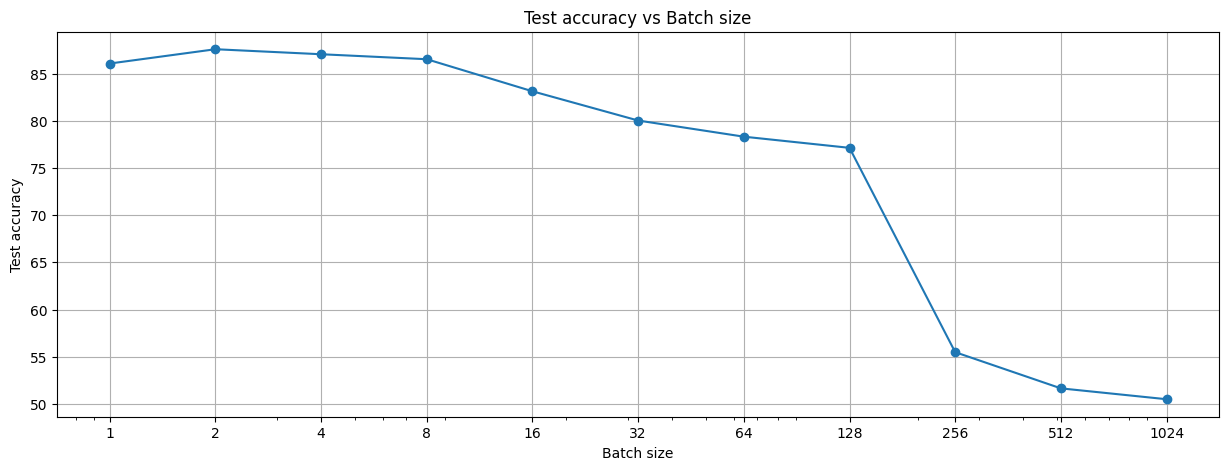

In [ ]:
# Plot test accuracy for each learning rate
plt.figure(figsize=(15, 5))
plt.plot(list(test_accuracies_by_batch_size.keys()), list(test_accuracies_by_batch_size.values()), marker='o')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Batch size')
plt.grid(True)

# Set xticks to all batch sizes
plt.xticks(list(test_accuracies_by_batch_size.keys()), list(test_accuracies_by_batch_size.keys()))

plt.show()

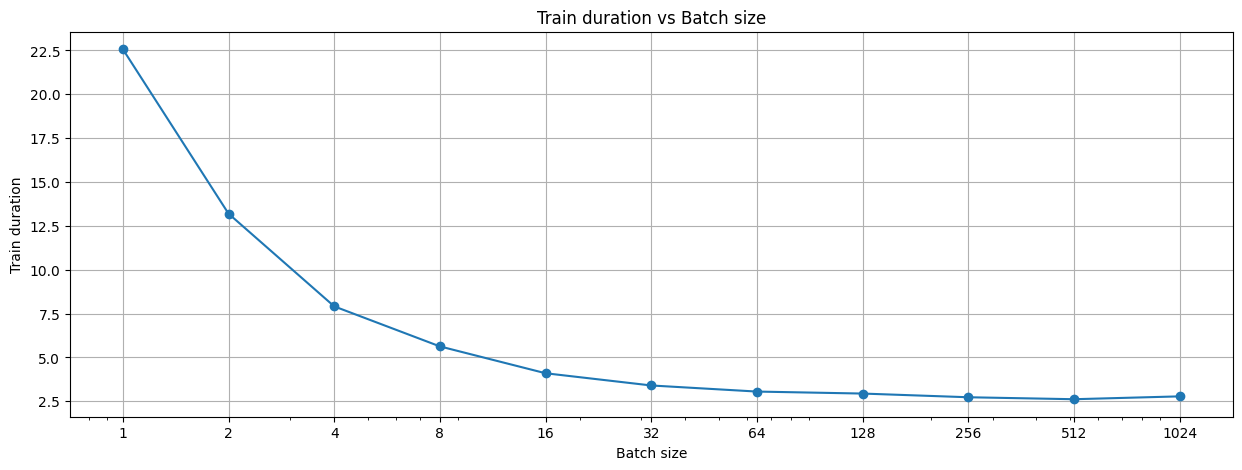

In [ ]:
# Plot test accuracy for each learning rate
plt.figure(figsize=(15, 5))
plt.plot(list(train_duration_by_batch_size.keys()), list(train_duration_by_batch_size.values()), marker='o')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Train duration')
plt.title('Train duration vs Batch size')
plt.grid(True)

# Set xticks to all batch sizes
plt.xticks(list(train_duration_by_batch_size.keys()), list(train_duration_by_batch_size.keys()))

plt.show()

A acurácia ficou maior para batchs menores. Isso pode ser ser explicado:

1. **Gradientes mais precisos:** Quando o tamanho do batch é menor, o gradiente calculado em cada etapa do treinamento é uma estimativa menos precisa do gradiente verdadeiro. Isso pode introduzir mais ruído no processo de treinamento, o que pode, paradoxalmente, ajudar o modelo a evitar mínimos locais e encontrar melhores soluções. Em contraste, quando o tamanho do batch é maior, o gradiente é uma estimativa mais precisa, mas isso pode fazer com que o modelo fique preso em mínimos locais.

2. **Mais atualizações de modelo:** Quando o tamanho do batch é menor, o modelo é atualizado com mais frequência. Por exemplo, se você tem 1000 exemplos de treinamento, um tamanho de batch de 1 resultará em 1000 atualizações de modelo por época, enquanto um tamanho de batch de 100 resultará em apenas 10 atualizações de modelo por época. Mais atualizações de modelo podem permitir que o modelo aprenda mais a partir dos dados.

3. **Regularização implícita:** O uso de tamanhos de batch menores também pode ter um efeito de regularização, ajudando a prevenir o overfitting. Isso ocorre porque o ruído introduzido pela estimativa do gradiente com menos exemplos pode ajudar a evitar que o modelo se ajuste demais aos dados de treinamento.

No entanto, vale a pena notar que embora tamanhos de batch menores possam às vezes resultar em uma acurácia de teste maior, eles também podem tornar o treinamento mais lento (gráfico 2), porque menos exemplos são processados simultaneamente. Além disso, tamanhos de batch muito pequenos podem resultar em estimativas de gradiente muito ruidosas, o que pode tornar o treinamento instável. Portanto, a escolha do tamanho do batch é um compromisso e pode requerer alguma experimentação para encontrar o melhor valor para um determinado problema.

## **IV - Modelo MLP**



A célula da seção IV - Modelo é provavelmente uma das mais difíceis de entender, juntamente com a seção V - Treinamento, pois são onde aparecem as principais funções do PyTorch.

Iremos utilizar uma rede neural de duas camadas ditas MLP (Multi-Layer Perceptron). São duas camadas lineares, fc1 e fc2. Essas camadas também são denominadas fully connected para diferenciar de camadas convolucionais. As camadas são onde estão os parâmetros (weights) da rede neural. É importante estudar como estas camadas lineares funcionam, elas são compostas de neurônios que fazem uma média ponderada pelos parâmetros W_i mais uma constante B_i. Esses parâmetros são treinados para minimizar a função de Loss. Uma função não linear é colocada entre as camadas lineares. No caso, usamos a função ReLU (Rectified Linear Unit).

Para entender o código da célula do Modelo MLP é fundamental conhecer os conceitos de orientação a objetos do Python. O modelo é definido pela classe OneHotMLP e é instanciado no objeto model na linha 16 que implementa o modelo da rede neural, recebendo uma entrada no formato one-hot e retornando o logito para ser posteriormente convertido em probabilidade do frase ser positiva ou negativa. O método forward será chamado automaticamente quando o objeto model for usado como função. Esses modelos são projetados para processar um batch de entrada de cada vez no formato devolvido pelo Data Loader visto na seção III (Exercício III.2.d)



### **IV.1** Exercícios para experimentar o modelo



#### **IV.1.a)** Faça a predição do modelo utilizando um batch do train_loader: extraia um batch do train_loader, chame de (input, target), onde input é a entrada da rede e target é o label esperado. Como a rede está com seus parâmetros (weights) aleatórios, o logito de saída da rede será um valor aleatório, porém a chamada irá executar sem erros:

logit = model( input)

aplique a função sigmoidal ao logito para convertê-lo numa probabilidade de valor entre 0 e 1.



In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 8,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)


In [ ]:

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device).view(-1)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# Aplique a função sigmoid aos logits
# A função sigmoid mapeia qualquer número real para o intervalo (0, 1),
# então as probabilidades resultantes serão valores entre 0 e 1.
# Essas probabilidades representam a saída do modelo: a probabilidade prevista
# de que cada exemplo de entrada pertença à classe positiva.
probabilities = torch.sigmoid(logits).view(-1)

predicted = torch.round(probabilities).view(-1)
total = targets.size(0)

correct = (predicted == targets)
total_correct = correct.sum().item()
accuracy = 100 * total_correct / total

print(f'logits {logits}')
print(f'probabilities {probabilities}')
print(f'predicted {predicted}')
print(f'targets {targets}')
print(f'correct {correct}')
print(f'correct {total_correct} of {total}')
print(f'accuracy {accuracy}')


logits tensor([[0.0377],
        [0.0645],
        [0.0222],
        [0.0132],
        [0.0496],
        [0.0317],
        [0.0464],
        [0.0325]], device='cuda:0', grad_fn=<AddmmBackward0>)
probabilities tensor([0.5094, 0.5161, 0.5056, 0.5033, 0.5124, 0.5079, 0.5116, 0.5081],
       device='cuda:0', grad_fn=<ViewBackward0>)
predicted tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<ViewBackward0>)
targets tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
correct tensor([False,  True,  True, False,  True,  True, False, False],
       device='cuda:0')
correct 4 of 8
accuracy 50.0


#### **IV.1.b)** Agora, treine a rede executando o notebook todo e verifique se a acurácia está alta. Agora repita o exercício anterior, porém agora, compare o valor da probabilidade encontrada com o target esperado e verifique se ele acertou. Você pode considerar que se a probabilidade for maior que 0.5, pode-se dar o label 1 e se for menor que 0.5, o label 0. Observe isso que é feito na linha 11 da seção VI - Avaliação.



Se você der um print no modelo: print(model), você obterá:
OneHotMLP(
  (fc1): Linear(in_features=20001, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (relu): ReLU()
)

Os pesos da primeira camada podem ser visualizados com:
model.fc1.weight
e o elemento constante (bias) pode ser visualizado com:
model.fc1.bias
Calcule o número de parâmetros do modelo, preenchendo a seguinte tabela (utilize shape
 para verificar a estrutura de cada parâmetro do modelo):

Tabela:
layer	fc1	            fc2	            TOTAL
  	   weight	bias	weight	bias
size




Treino completo

In [ ]:
test_loader = DataLoader(test_data,
                          batch_size= 8,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
print(f"test_loader tem {len(test_loader)} batches")


test_loader tem 3125 batches


In [ ]:
# Initialize a dictionary to record test accuracy for each learning rate

train_loader = DataLoader(train_data,
                        batch_size= 8,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_start_time = time.time()  # Start time of the epoch
test_accuracy = train_model(model, criterion, optimizer, 5, train_loader, test_loader, verbose=False)

train_duration = time.time() - train_start_time  # Duration of epoch


print(f'Treino [{cnt_treino + 1}/{len(batch_size_list)}]: batch_size={batch_size}; Número de batches de treino: {len(train_loader)}; test_accuracy={round(test_accuracy,4)}  (train_duration {train_duration:.2f} sec)')



Treino [11/11]: batch_size=1024; Número de batches de treino: 3125; test_accuracy=87.732  (train_duration 22.75 sec)


Verificação da acurácia após treino

In [ ]:
list_data_loader = [{'treino':train_loader}, {'teste':test_loader, }]
# Obtenha o primeiro batch do train_loader
for data_loader_avaliacao in list_data_loader:
    #print(data_loader_avaliacao)
    nome_data_loader = list(data_loader_avaliacao.keys())[0]
    #print(nome_data_loader)
    data_loader = data_loader_avaliacao[nome_data_loader]
    #print(data_loader)
    inputs, targets = next(iter(data_loader))

    # Mova os inputs e targets para o dispositivo onde o modelo está
    inputs = inputs.to(device)
    targets = targets.to(device).view(-1)

    # Passe os inputs pelo modelo
    # Isso retorna os logits, que são os valores brutos de saída do modelo.
    # Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
    logits = model(inputs)

    # Aplique a função sigmoid aos logits
    # A função sigmoid mapeia qualquer número real para o intervalo (0, 1),
    # então as probabilidades resultantes serão valores entre 0 e 1.
    # Essas probabilidades representam a saída do modelo: a probabilidade prevista
    # de que cada exemplo de entrada pertença à classe positiva.
    probabilities = torch.sigmoid(logits).view(-1)

    predicted = torch.round(probabilities).view(-1)
    total = targets.size(0)

    correct = (predicted == targets)
    total_correct = correct.sum().item()
    accuracy = 100 * total_correct / total

    print(f'\n\nEm ambiente de: {nome_data_loader}')

    print(f'logits {logits}')
    print(f'probabilities {probabilities}')
    print(f'predicted {predicted}')
    print(f'targets {targets}')
    print(f'correct {correct}')
    print(f'correct {total_correct} of {total}')
    print(f'accuracy {accuracy}')




Em ambiente de: treino
logits tensor([[-7.3362],
        [ 0.6910],
        [ 4.8479],
        [-4.7868],
        [ 0.9367],
        [ 7.0848],
        [ 0.8461],
        [ 4.5086]], device='cuda:0', grad_fn=<AddmmBackward0>)
probabilities tensor([6.5110e-04, 6.6619e-01, 9.9222e-01, 8.2704e-03, 7.1844e-01, 9.9916e-01,
        6.9975e-01, 9.8911e-01], device='cuda:0', grad_fn=<ViewBackward0>)
predicted tensor([0., 1., 1., 0., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<ViewBackward0>)
targets tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
correct tensor([True, True, True, True, True, True, True, True], device='cuda:0')
correct 8 of 8
accuracy 100.0


Em ambiente de: teste
logits tensor([[ 7.8473],
        [ 1.2208],
        [ 0.1196],
        [ 9.2927],
        [-5.5199],
        [ 3.4430],
        [ 2.6541],
        [ 7.4055]], device='cuda:0', grad_fn=<AddmmBackward0>)
probabilities tensor([0.9996, 0.7722, 0.5299, 0.9999, 0.0040, 0.9690, 0.9343, 0.9994],
       device='cuda

**Observação** Como esperado, a acurácia nos dados de treinamento alcançou 100%, mas em teste 87.5%. O modelo ficou especialista nos dados de treinamento.

Obtendo o total dos parâmetros

In [ ]:
print(model)

OneHotMLP(
  (fc1): Linear(in_features=20001, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
model.fc1.weight.size(), model.fc1.bias.size()

(torch.Size([200, 20001]), torch.Size([200]))

In [ ]:

# Initialize dictionaries to hold the counts and shapes
param_counts = {}
param_shapes = {}
layer_counts = {}

# Iterate over each parameter
for name, param in model.named_parameters():
    # Update the count and shape for this parameter
    param_counts[name] = param.numel()
    param_shapes[name] = list(param.size())

    # Get the layer name and update the layer count
    layer_name = name.split('.')[0]
    layer_counts[layer_name] = layer_counts.get(layer_name, 0) + param.numel()

# Print the number of parameters and shape for each weight and bias in each layer
for param_name in param_counts.keys():
    print(f'{param_name}: {param_counts[param_name]} parameters, shape {param_shapes[param_name]}')

# Print the total number of parameters in each layer
for layer_name in layer_counts.keys():
    print(f'{layer_name}: {layer_counts[layer_name]} total parameters')

# Calculate and print the total number of parameters in the model
total_params = sum(param_counts.values())
print(f'Total parameters in the model: {total_params}')


fc1.weight: 4000200 parameters, shape [200, 20001]
fc1.bias: 200 parameters, shape [200]
fc2.weight: 200 parameters, shape [1, 200]
fc2.bias: 1 parameters, shape [1]
fc1: 4000400 total parameters
fc2: 201 total parameters
Total parameters in the model: 4000601


|layer||||||
|------|------|------|------|------|------|
||weight|total|bias|total|total|
|fc1|[200, 20001]|4000200|[200]|200|4000400|
|fc2|[1, 200]|200|[1]|1|201|
|total||4000400||201|4000601|

## **V - Treinamento**



Agora vamos entrar na principal seção do notebook que minimiza a Loss para ajustar os pesos do modelo.

Cálculo da Loss

A Loss é uma comparação entre a saída do modelo e o label (target). A Loss mais utilizada para problemas de classificação é a Entropia Cruzada. A equação da entropia cruzada para o caso binário (2 classes: 0 ou 1; True ou False) é dada por:

H = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(p_i) + (1 - y_i) \log(1 - p_i)

Nessa fórmula:

(H) é a entropia cruzada.
(N) é o número de amostras.
(y_i) é o rótulo verdadeiro da amostra (i).
(p_i) é a probabilidade prevista pelo modelo para a amostra (i).

Muitas vezes chamamos y_i de target e p_i (y_i ) ̂ de prob.

Quando a Loss é zero, significa que o modelo está predizendo tanto as amostras positivas como as amostras negativas com probabilidade de 100%. O objetivo é otimizar o modelo para conseguir minimizar a Loss ao máximo.

A rede neural é o nosso modelo que recebe a entrada com um batch de amostras e retorna um batch de logitos ou output.

output = model(input)

para converter o logito (output) em probabilidade, utiliza-se a função sigmóide que é dada pela equação específica
  

Assim, o código pytorch para estimarmos a probabilidade de um texto codificado no formato one-hot na variável input pode ser:

prob = torch.sigmoid(output)

Atenção: observe que esses comandos estão processando todas as amostras no batch, que nesse notebook tem 128 amostras no batch size.



### **V.1 Exercícios:**


#### **V.1.a)** Qual é o valor teórico da Loss quando o modelo não está treinado, mas apenas inicializado? Isto é, a probabilidade predita tanto para a classe 0 como para a classe 1, é sempre 0,5 ? Justifique. Atenção: na equação da Entropia Cruzada utilize o logaritmo natural.



**R.:**
A função de perda de entropia cruzada binária, que é comumente usada para problemas de classificação binária, é definida como:

```
BCELoss = -[y * log(p) + (1 - y) * log(1 - p)]
```

onde `y` é o rótulo verdadeiro (0 ou 1) e `p` é a probabilidade prevista para a classe 1.

Quando o modelo é apenas inicializado e não treinado, e se assumirmos que ele está prevendo uma probabilidade de 0,5 para ambas as classes (o que seria o caso se o modelo estivesse prevendo aleatoriamente), então a função de perda de entropia cruzada binária se simplifica para:

```
BCELoss = -[y * log(0.5) + (1 - y) * log(0.5)]
        = -log(0.5)
        = log(2)
```

O logaritmo natural de 2 é aproximadamente 0.6931. Portanto, o valor teórico da perda quando o modelo não está treinado e está prevendo uma probabilidade de 0,5 para ambas as classes é aproximadamente 0.6931.

Obs.:note que isso é apenas uma aproximação teórica. Na prática, um modelo recém-inicializado pode não prever exatamente 0,5 para todas as entradas, dependendo de como seus pesos são inicializados. Além disso, a perda real também dependerá da distribuição dos rótulos verdadeiros `y` no conjunto de dados.

#### **V.1.b)** Utilize as amostras do primeiro batch: (input,target) = next(iter(train_loader)) e calcule o valor da Loss utilizando a equação fornecida anteriormente utilizando o pytorch. Verifique se este valor confere com o valor teórico do exercício anterior.



In [ ]:
# Suponha que você já tenha definido train_data, vocab_size e OneHotMLP

train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

# Instanciação do modelo
model = OneHotMLP(vocab_size)
model = model.to(device)

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device).view(-1)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# Aplique a função sigmoid aos logits
# A função sigmoid mapeia qualquer número real para o intervalo (0, 1),
# então as probabilidades resultantes serão valores entre 0 e 1.
# Essas probabilidades representam a saída do modelo: a probabilidade prevista
# de que cada exemplo de entrada pertença à classe positiva.
probabilities = torch.sigmoid(logits).view(-1)

# Calcule a entropia cruzada manualmente
# A fórmula é: - (y * log(p) + (1 - y) * log(1 - p))
# onde y é a classe real (0 ou 1) e p é a probabilidade prevista
loss = -(targets * torch.log(probabilities) + (1 - targets) * torch.log(1 - probabilities)).mean()

print(f'loss {loss.item()}')


loss 0.6965450048446655


**R,:** valor confere com o teórico

#### **V.1.c)** O pytorch possui várias funções que facilitam o cálculo da Loss pela Entropia Cruzada. Utilize a classe nn.BCELoss (Binary Cross Entropy Loss). Você primeiro deve instanciar uma função da classe nn.BCELoss. Esta função instanciada recebe dois parâmetros (probs , targets) e retorna a Loss. Use a busca do Google para ver a documentação do BCELoss do pytorch.


Calcule então a função de Loss da entropia cruzada, porém usando agora a função instanciada pelo BCELoss e confira se o resultado é exatamente o mesmo obtido no exercício anterior.



Para usar a classe `nn.BCELoss` (Binary Cross Entropy Loss) em vez de `nn.BCEWithLogitsLoss`, você precisa aplicar a função sigmoid aos logits antes de passá-los para a função de perda.


Neste exemplo, a linha `loss = criterion(probabilities, targets.float())` aplica a função de perda `nn.BCELoss` às probabilidades, não aos logits. A função `nn.BCELoss` espera que as entradas sejam probabilidades entre 0 e 1, então você precisa aplicar a função sigmoid aos logits antes de passá-los para a função de perda.


Sim. Diferenças nas casas decimais provavelmente devido a arredondamentos e representação numérica.

In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 128,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCELoss()

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device).view(-1)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# Aplique a função sigmoid aos logits
# A função sigmoid mapeia qualquer número real para o intervalo (0, 1),
# então as probabilidades resultantes serão valores entre 0 e 1.
# Essas probabilidades representam a saída do modelo: a probabilidade prevista
# de que cada exemplo de entrada pertença à classe positiva.
probabilities = torch.sigmoid(logits).view(-1)

predicted = torch.round(probabilities).view(-1)
total = targets.size(0)

correct = (predicted == targets)
total_correct = correct.sum().item()
accuracy = 100 * total_correct / total

# Apply the loss function to the probabilities, not the logits
loss = criterion(probabilities, targets.float())

print(f'loss {loss.item()}')


loss 0.6915096044540405


#### **V.1.d)** Repita o mesmo exercício, porém agora usando a classe nn.BCEWithLogitsLoss, que é a opção utilizada no notebook. O resultado da Loss deve igualar aos resultados anteriores.



Minimização da Loss pelo gradiente descendente

Estude o método do gradiente descendente para minimizar uma função. Como curiosidade, pergunte ao chatGPT quando este método de minimização foi usado pela primeira vez. Aproveite e peça para ele explicar o método de uma maneira bem simples e ilustrativa. Peça para ele explicar qual é a forma moderna de se calcular computacionalmente o gradiente de uma função.
Finalmente peça para ele explicar as linhas 3, 6, e (20, 21 e 22) do laço de treinamento.



In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 128,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device).view(-1)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# Aplique a função sigmoid aos logits
# A função sigmoid mapeia qualquer número real para o intervalo (0, 1),
# então as probabilidades resultantes serão valores entre 0 e 1.
# Essas probabilidades representam a saída do modelo: a probabilidade prevista
# de que cada exemplo de entrada pertença à classe positiva.
probabilities = torch.sigmoid(logits).view(-1)

predicted = torch.round(probabilities).view(-1)
total = targets.size(0)

correct = (predicted == targets)
total_correct = correct.sum().item()
accuracy = 100 * total_correct / total

loss = criterion(logits.view(-1), targets.float())

print(f'loss {loss.item()}')



loss 0.6923476457595825


### **V.2 Exercícios:**


#### **V.2.a)** Modifique a célula do laço de treinamento de modo que a primeira Loss a ser impressa seja a Loss com o modelo inicializado (isto é, sem nenhum treinamento), fornecendo a Loss esperada conforme os exercícios feitos anteriormente. Observe que desta forma, fica fácil verificar se o seu modelo está correto e a Loss está sendo calculada corretamente.


Atenção: Mantenha esse código da impressão do valor da Loss inicial, antes do treinamento, nesta célula, pois ela é sempre útil para verificar se não tem nada errado, antes de começar o treinamento.



In [ ]:
criterion.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict([('weight', None), ('pos_weight', None)]),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'reduction': 'mean'}

In [ ]:
def validar_correcao_loss_esperada_xentropy(model, criterion, train_loader):

    # Forward pass com o modelo inicializado
    # Obtenha o primeiro batch do train_loader
    inputs, targets = next(iter(train_loader))

    # Mova os inputs e targets para o dispositivo onde o modelo está
    inputs = inputs.to(device)
    targets = targets.to(device).view(-1)

    initial_outputs = model(inputs)  # Inputs devem ser do DataLoader de treinamento
    loss = criterion(initial_outputs.view(-1), targets.float())

    # Valor esperado da Loss
    valor_esperado = 0.6931

    diff = abs(loss.item()-valor_esperado)
    # Verifique se a Loss inicial está próxima do valor esperado
    if diff < 0.01:  # Considerando igualdade até 2 casas decimais
        print(f"A Loss inicial de cross entropy {loss} está correta! Diferença de {diff:.4f} (arredondamentos)")
        return True
    else:
        print(f"A Loss inicial de cross entropy não corresponde ao valor esperado. Valor atual: {loss.item():.4f}. Valor esperado para loss: {valor_esperado:.4f}. Diferença de {diff:.4f}")
        return False



In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 128,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()


print(validar_correcao_loss_esperada_xentropy(model, criterion, train_loader))




A Loss inicial de cross entropy 0.693384051322937 está correta! Diferença de 0.0003 (arredondamentos)
True


In [ ]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, verbose:bool=True):

    if validar_correcao_loss_esperada_xentropy(model, criterion, train_loader):
        # Training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # Start time of the epoch
            model.train()
            for cnt_batch, (inputs, labels) in enumerate(train_loader):


                # print(f"Batch {cnt+1}")
                # mover para gpu
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(inputs)
                if verbose and cnt_batch==0:
                    # Verifique as dimensões dos tensores
                    print("Dimensões dos outputs:", outputs.shape)
                    print("Dimensões dos labels:", labels.shape)
                loss = criterion(outputs.view(-1), labels.view(-1).float())
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_duration = time.time() - epoch_start_time  # Duration of epoch

            if verbose:
                print(f'Epoch [{epoch+1}/{num_epochs}], \
                        Loss: {loss.item():.4f}, \
                        Elapsed Time: {epoch_duration:.2f} sec')

        # Evaluate the model and record the test accuracy
        test_accuracy = evaluate(model, test_loader)

        return test_accuracy



#### **V.2.b)** Execute a célula de treinamento por uma segunda vez e observe que a Loss continua diminuindo e o modelo está continuando a ser treinado. O que é necessário fazer para que o treinamento comece novamente do modelo aleatório? Qual(is) célula(s) é(são) preciso executar antes de executar o laço de treinamento novamente?


In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 8,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_start_time = time.time()  # Start time of the epoch
test_accuracy = train_model(model, criterion, optimizer, 1, train_loader, test_loader, verbose=False)
test_accuracy = train_model(model, criterion, optimizer, 1, train_loader, test_loader, verbose=False)


A Loss inicial de cross entropy 0.6963748931884766 está correta! Diferença de 0.0033 (arredondamentos)
A Loss inicial de cross entropy não corresponde ao valor esperado. Valor atual: 0.1784. Valor esperado para loss: 0.6931. Diferença de 0.5147


Realmente não corresponde à inicial, pois os parâmetros do modelo fora atualizados e ela diminuiu (houve aprendizado).
Para recomeçar em modo aleatório é necessário reiniciar os parâmetros, recriando-se o modelo com o comando model = OneHotMLP(vocab_size). Conforme abaixo:

In [ ]:
train_loader = DataLoader(train_data,
                        batch_size= 8,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_start_time = time.time()  # Start time of the epoch
test_accuracy = train_model(model, criterion, optimizer, 1, train_loader, test_loader, verbose=False)
model = OneHotMLP(vocab_size)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
test_accuracy = train_model(model, criterion, optimizer, 1, train_loader, test_loader, verbose=False)


A Loss inicial de cross entropy 0.6940696239471436 está correta! Diferença de 0.0010 (arredondamentos)
A Loss inicial de cross entropy 0.6977269053459167 está correta! Diferença de 0.0046 (arredondamentos)


### **V.3 Exercícios:**




Modificando a rede para gerar dois logitos no lugar de 1

Existe uma forma alternativa de implementar um modelo binário utilizando 2 logitos, um para dar a probabilidade da classe positiva e outro para a classe negativa. Para isso, modifique a camada de saída da rede para gerar 2 logitos no lugar de apenas 1 logito.
Agora, para converter os logitos em probabilidade, é necessário utilizar a função Softmax, que é dada pela equação:

A função Softmax é usada para prever mais de 2 classes, mas também pode ser usada para o nosso caso de 2 classes. Quando existem N classes, utiliza-se N logitos na saída da rede neural. O Softmax converte estes n logitos em N probabilidades de modo que a soma destas probabilidades é sempre igual a 1, não importando os valores dos logitos que podem assumir quaisquer valores, negativos ou positivos.

O valor da Loss para o caso de N classes e M amostras no batch, é dado por fórmulas específicadas no material.




#### **V.3.a)** Repita o exercício V.1.a) porém agora utilizando a equação acima.



In [ ]:
class OneHotMLPClasses(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(OneHotMLPClasses, self).__init__()
        self.fc1 = nn.Linear(vocab_size + 1, 200)
        self.fc2 = nn.Linear(200, num_classes)  # Duas saídas para as classes positiva e negativa
        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

In [ ]:
# Suponha que você já tenha definido train_data, vocab_size e OneHotMLP

train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

# Instanciação do modelo
model = OneHotMLPClasses(vocab_size,2)
model = model.to(device)

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# Calculate the softmax manually
exp_logits = torch.exp(logits)
sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
probabilities = exp_logits / sum_exp_logits


#print(f'targets {targets}')
#print(f'logits {logits}')
#print(f'probabilities {probabilities}')


# Calcule a entropia cruzada manualmente
# A fórmula é: - (y * log(p) + (1 - y) * log(1 - p))
# onde y é a classe real (0 ou 1) e p é a probabilidade prevista
# loss = -(targets * torch.log(probabilities) + (1 - targets) * torch.log(1 - probabilities)).mean()



# Convert targets to one-hot encoding
targets_one_hot = torch.nn.functional.one_hot(targets)

# Calculate the cross-entropy loss manually
# torch.nn.functional.one_hot(targets) converte targets para a codificação one-hot.
# A fórmula -(targets_one_hot * torch.log(probabilities)).sum() / targets.size(0)
# calcula a entropia cruzada multiclasse, que é a soma negativa das probabilidades
# logarítmicas previstas para as classes verdadeiras, dividida pelo número de amostras.

# note que isso pressupõe que targets é um tensor de rótulos de classe e que probabilities
# é um tensor de probabilidades previstas que soma 1 ao longo da dimensão das classes.
loss = -(targets_one_hot * torch.log(probabilities)).sum() / targets.size(0)


print(f'loss {loss.item()}')


loss 0.6964499950408936


#### **V.3.b)** Modifique a camada de saída da rede para 2 logitos e utilize a função Softmax para converter os logitos em probabilidades. Repita o exercício V.1.b)



In [ ]:
# Suponha que você já tenha definido train_data, vocab_size e OneHotMLP

train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

# Instanciação do modelo
model = OneHotMLPClasses(vocab_size,2)
model = model.to(device)

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# A função softmax mapeia probabilidades
probabilities = torch.softmax(logits, dim=1)

#print(f'targets {targets}')
#print(f'logits {logits}')
#print(f'probabilities {probabilities}')


# Calcule a entropia cruzada manualmente
# A fórmula é: - (y * log(p) + (1 - y) * log(1 - p))
# onde y é a classe real (0 ou 1) e p é a probabilidade prevista
# loss = -(targets * torch.log(probabilities) + (1 - targets) * torch.log(1 - probabilities)).mean()



# Convert targets to one-hot encoding
targets_one_hot = torch.nn.functional.one_hot(targets)

# Calculate the cross-entropy loss manually
# torch.nn.functional.one_hot(targets) converte targets para a codificação one-hot.
# A fórmula -(targets_one_hot * torch.log(probabilities)).sum() / targets.size(0)
# calcula a entropia cruzada multiclasse, que é a soma negativa das probabilidades
# logarítmicas previstas para as classes verdadeiras, dividida pelo número de amostras.

# note que isso pressupõe que targets é um tensor de rótulos de classe e que probabilities
# é um tensor de probabilidades previstas que soma 1 ao longo da dimensão das classes.
loss = -(targets_one_hot * torch.log(probabilities)).sum() / targets.size(0)


print(f'loss {loss.item()}')


loss 0.6906419992446899


#### **V.3.c)** Utilize agora a função nn.CrossEntropyLoss para calcular a Loss e verifique se os resultados são os mesmos que anteriormente.



In [ ]:
# Suponha que você já tenha definido train_data, vocab_size e OneHotMLP

train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

# Instanciação do modelo
model = OneHotMLPClasses(vocab_size,2)
model = model.to(device)

# Obtenha o primeiro batch do train_loader
inputs, targets = next(iter(train_loader))

# Mova os inputs e targets para o dispositivo onde o modelo está
inputs = inputs.to(device)
targets = targets.to(device)

# Passe os inputs pelo modelo
# Isso retorna os logits, que são os valores brutos de saída do modelo.
# Como o modelo ainda não foi treinado, esses valores são inicialmente aleatórios.
logits = model(inputs)

# A função softmax mapeia probabilidades
probabilities = torch.softmax(logits, dim=1)

# Instantiate the loss function
criterion = nn.CrossEntropyLoss()

# Calculate the loss
loss = criterion(logits, targets)

print(f'loss {loss.item()}')


loss 0.6907879710197449


#### **V.3.d)** Modifique as seções V e VI para que o notebook funcione com a saída da rede com 2 logitos. Há necessidade de alterar o laço de treinamento e o laço de cálculo da acurácia.



In [ ]:
def evaluate(model, test_loader):
    ## evaluation
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            if outputs.shape[1] == 1: # gera 1 logito
                predicted = torch.round(torch.sigmoid(outputs)).view(-1)
            else: # gera mais de um logito, um para cada classe
                predicted = torch.argmax(outputs, dim=1).view(-1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()

        test_accuracy = 100 * correct / total

        return test_accuracy


In [ ]:
def validar_correcao_loss_esperada_xentropy(model, criterion, train_loader):

    # Forward pass com o modelo inicializado
    # Obtenha o primeiro batch do train_loader
    inputs, targets = next(iter(train_loader))

    # Mova os inputs e targets para o dispositivo onde o modelo está
    inputs = inputs.to(device)
    targets = targets.to(device).view(-1)

    initial_outputs = model(inputs)  # Inputs devem ser do DataLoader de treinamento


    if initial_outputs.shape[1] == 1: # gera 1 logito
        loss = criterion(initial_outputs.view(-1), targets.view(-1).float())
    else: # gera mais de um logito, um para cada classe
        loss = criterion(nn.functional.softmax(initial_outputs, dim=1), targets)

    # Valor esperado da Loss
    valor_esperado = 0.6931

    diff = abs(loss.item()-valor_esperado)
    # Verifique se a Loss inicial está próxima do valor esperado
    if diff < 0.01:  # Considerando igualdade até 2 casas decimais
        print(f"A Loss inicial de cross entropy {loss} está correta! Diferença de {diff:.4f} (arredondamentos)")
        return True
    else:
        print(f"A Loss inicial de cross entropy não corresponde ao valor esperado. Valor atual: {loss.item():.4f}. Valor esperado para loss: {valor_esperado:.4f}. Diferença de {diff:.4f}")
        return False



In [ ]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, verbose:bool=True):

    if validar_correcao_loss_esperada_xentropy(model, criterion, train_loader):
        # Training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # Start time of the epoch
            model.train()
            for cnt_batch, (inputs, labels) in enumerate(train_loader):
                # print(f"Batch {cnt+1}")
                # mover para gpu
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(inputs)
                if verbose and cnt_batch==0:
                    # Verifique as dimensões dos tensores
                    print("Dimensões dos outputs:", outputs.shape)
                    print("Dimensões dos labels:", labels.shape)


                if outputs.shape[1] == 1: # gera 1 logito
                    loss = criterion(outputs.view(-1), labels.view(-1).float())
                else:  # gera mais de um logito, um para cada classe
                    loss = criterion(nn.functional.softmax(outputs, dim=1), labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_duration = time.time() - epoch_start_time  # Duration of epoch

            if verbose:
                print(f'Epoch [{epoch+1}/{num_epochs}], \
                        Loss: {loss.item():.4f}, \
                        Elapsed Time: {epoch_duration:.2f} sec')

        # Evaluate the model and record the test accuracy
        test_accuracy = evaluate(model, test_loader)

        return test_accuracy



## **VI - Avaliação**



Observe que o módulo de avaliação utiliza o test_loader que foi carregado do dataset IMDB especialmente preparado para fazer a avaliação.



### **VI.1 Exercícios:**



#### **VI.1.a)** Calcule o número de amostras que está sendo considerado na seção de avaliação.


In [ ]:
print(f'O total de amostras avaliadas em teste é: {len(test_loader.dataset)} em {len(test_loader)} batches')

O total de amostras avaliadas em teste é: 25000 em 3125 batches


#### **VI.1.b)** Explique o que faz os comandos model.eval()e with torch.no_grad().


R.:

1. **model.eval():** Quando você chama `model.eval()`, você está essencialmente definindo o modelo (nn.Module) para o modo de avaliação. Isso tem efeitos em certas camadas do seu modelo, como Dropout e BatchNorm, que se comportam de maneira diferente durante o treinamento e durante a avaliação. Por exemplo, durante o treinamento, a camada Dropout irá aleatoriamente zerar algumas das entradas, mas durante a avaliação (ou seja, quando o modelo está em modo `.eval()`), a camada Dropout não alterará suas entradas. Da mesma forma, a camada BatchNorm usará estatísticas de execução durante o treinamento, mas usará estatísticas acumuladas durante a avaliação. Embora o modelo possa não possuir essas camadas, há sempre a possibilidade de ele ser evoluído. Outra motivação é a legibilidade do código:  deixa claro para qualquer pessoa que esteja lendo o seu código que essa parte do código está fazendo a avaliação do modelo, não o treinamento. Tem também a compatibilidade com outras bibliotecas de aprendizado profundo ou funções do PyTorch que podem ser afetadas com essa informação do modelo.

2. **with torch.no_grad():** Em PyTorch, cada operação em tensores que têm `requires_grad=True` irá criar um histórico de computação que permite calcular gradientes usando backpropagation. No entanto, durante a avaliação do modelo, você geralmente não precisa de gradientes, porque você não está atualizando os pesos do modelo. O uso de `with torch.no_grad():` desativa a criação desse histórico de computação, o que pode reduzir o uso de memória e acelerar os cálculos. Isso é especialmente útil durante a avaliação do modelo, quando você normalmente só precisa passar os dados através do modelo e calcular a perda ou as métricas de avaliação, sem precisar atualizar os pesos do modelo.

#### **VI.1.c)** Existe uma forma mais simples de calcular a classe predita na linha 11, sem a necessidade de usar a função torch.sigmoid?


**R.:**
Sim, existe uma maneira mais simples de calcular a classe predita sem a necessidade de usar a função torch.sigmoid. A função torch.sigmoid é usada para mapear os valores de saída do modelo para o intervalo entre 0 e 1, que pode ser interpretado como a probabilidade da classe positiva. No entanto, se você está apenas interessado na classe predita e não na probabilidade, você pode simplesmente usar a função torch.round diretamente nos valores de saída do modelo.

Aqui está como você pode fazer isso:

```python
        predicted = torch.round(outputs).view(-1)
```

Neste caso, os valores de saída do modelo que são maiores que 0 serão arredondados para 1 (classe positiva) e os valores que são menores ou iguais a 0 serão arredondados para 0 (classe negativa).

No entanto, é importante notar que esta abordagem só é válida se você estiver usando uma função de perda que já inclua a função sigmoid, como a Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss) no PyTorch. Se você estiver usando uma função de perda que não inclui a função sigmoid, como a Binary Cross-Entropy Loss (BCELoss), você ainda precisará aplicar a função sigmoid aos valores de saída do modelo antes de arredondá-los.

### **VI.2 Exercícios:**



Perplexidade como métrica de avaliação

Em teoria da informação, a perplexidade (PPL) é dada por


$
PPL = e^{CE}
$

onde CE é a Cross Entropy, que utilizamos na Loss do treinamento. A base e utilizada para a exponenciação deve ser compatível com a base utilizado no logaritmo da cross entropia. Como utilizamos logaritmo natural para a entropia cruzada, devemos aqui usar o e. Se a entropia cruzada usasse a base 2, a perplexidade seria 2 elevado à entropia cruzada.

Eu, particularmente gosto de usar a perplexidade em vez de usar a entropia cruzada pelo motivo que ficará explícito nos exercícios a seguir:



#### **VI.2.a)** Utilizando a resposta do exercício V.1.a, que é a Loss teórica de um modelo aleatório de 2 classes, qual é o valor da perplexidade?


O Valor é 2

In [ ]:
np.log(2)

0.6931471805599453

In [ ]:
print(f'O valor é {round(math.e**np.log(2),3)}')

O valor é 2.0


#### **VI.2.b)** E se o modelo agora fosse para classificar a amostra em N classes, qual seria o valor da perplexidade para o caso aleatório?


**R.:**
Seria N.

A perplexidade é uma medida comumente usada para avaliar modelos de linguagem. Ela é definida como a potência inversa da probabilidade média do modelo de prever a classe correta. Em outras palavras, a perplexidade de um modelo é o número de escolhas igualmente prováveis que ele efetivamente tem ao fazer uma previsão.

Se um modelo está fazendo previsões aleatórias para um problema de classificação com N classes, então a probabilidade de prever a classe correta para qualquer amostra é 1/N. Portanto, a perplexidade para o caso aleatório seria N.

Aqui está a justificativa matemática para isso:

A perplexidade (PPL) é definida como a exponencial da entropia cruzada (CE), que é uma medida da diferença entre duas distribuições de probabilidade. A fórmula da perplexidade é:

$PPL = e^{CE}$

A entropia cruzada para o caso aleatório é:

${CE} = - ∑ (1/N) log (1/N) = log N$

Portanto, a perplexidade para o caso aleatório é:

$PPL = e^{log N} = N$

Isso significa que, para um modelo que faz previsões aleatórias para um problema de classificação com N classes, a perplexidade é N. Em outras palavras, o modelo tem efetivamente N escolhas igualmente prováveis ao fazer uma previsão.

#### **VI.2.c)** Qual é o valor da perplexidade quando o modelo acerta todas as classes com 100% de probabilidade?

Se você respondeu corretamente as 3 questões acima, já é possível entender que a perplexidade é muito mais fácil de entender o seu significado do que o valor da Loss como entropia cruzada.



**R.:**
Se um modelo de classificação é capaz de prever a classe correta para todas as amostras com 100% de probabilidade, então a perplexidade do modelo é 1.

Aqui está a justificativa matemática.

Se o modelo está prevendo a classe correta com 100% de probabilidade, então a distribuição de probabilidade prevista pelo modelo é a mesma que a distribuição de probabilidade verdadeira. Nesse caso, a entropia cruzada é 0, porque a entropia cruzada é mínima quando as duas distribuições p(x) e q(x) (calculada pelo modelo) são iguais.

A entropia cruzada é definida como:

${CE(p,q)} =  - ∑ p(x) log (q(x))$

Nesse caso, para a classe correta, temos p(x) = 1 e q(x) = 1. Portanto, o termo correspondente na soma da entropia cruzada é -1 * log(1) = 0, porque o logaritmo de 1 é 0. Para todas as outras classes, temos p(x) = 0. Portanto, os termos correspondentes na soma da entropia cruzada são 0 * log(q(x)) = 0, porque qualquer número multiplicado por 0 é 0. Portanto, a entropia cruzada é a soma de muitos termos 0, o que resulta em 0.


Portanto, a perplexidade quando o modelo acerta todas as classes com 100% de probabilidade é:

$PPL = {CE}^0 = 1$

Isso significa que, para um modelo perfeito que acerta todas as classes com 100% de probabilidade, a perplexidade é 1. Em outras palavras, o modelo tem efetivamente uma única escolha ao fazer uma previsão.

### **VI.3 Exercícios:**


#### **VI.3.a)** Modifique o código da seção VI - Avaliação, para que além de calcular a acurácia, calcule também a perplexidade. lembrar que PPL = torch.exp(CE). Assim, será necessário calcular a entropia cruzada, como feito no laço de treinamento.


In [ ]:
def evaluate(model, test_loader, criterion):
    ## evaluation
    model.eval()

    with torch.no_grad():
        correct = 0
        total = len(test_loader.dataset)
        total_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            if outputs.shape[1] == 1: # gera 1 logito
                predicted = torch.round(torch.sigmoid(outputs)).view(-1)
                loss = criterion(outputs.view(-1), labels.view(-1).float())
            else: # gera mais de um logito, um para cada classe
                predicted = torch.argmax(outputs, dim=1).view(-1)
                loss = criterion(nn.functional.softmax(outputs, dim=1), labels)
            total_loss += loss.item()
            correct += (predicted == labels.view(-1)).sum().item()

        test_accuracy = 100 * correct / total
        test_loss = total_loss / len(test_loader)
        test_perplexity = torch.exp(torch.tensor(test_loss))
        return test_accuracy, test_perplexity


### **VI.4 Último exercício:**



Observando Overfitting

Dizemos que o treinamento está overfitting quando treina-se tanto nas mesmas amostras, de modo quase a decorá-lo e quando o modelo fizer a predição em um outro conjunto de amostras, ele não consegue "generalizar" o conhecimento aprendido no treinamento. Uma forma de detectar se o treinamento está entrando no overfitting é calcular, durante o laço de treinamento, tanto a loss de minimização no conjunto de treino, porém ao final de cada época, calcular a loss ou alguma métrica relacionada ao conjunto de teste ou validação.



#### **VI.4.a)** Modifique o laço de treinamento

 para incorporar também o cálculo da avaliação ao final de cada época. Aproveite para reportar também a perplexidade, tanto do treinamento como da avaliação (observe que será mais fácil de interpretar). Essa é a forma usual de se fazer o treinamento, monitorando se o modelo não entra em overfitting. Por fim, como o dataset tem muitas amostras, ele é demorado de entrar em overfitting. Para ficar mais evidente, diminua novamente o número de amostras do dataset de treino de 25 mil para 1 mil amostras e aumente o número de épocas para ilustrar o caso do overfitting, em que a perplexidade de treinamento continua caindo, porém a perplexidade no conjunto de teste começa a aumentar.




In [ ]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, verbose:bool=True):

    if validar_correcao_loss_esperada_xentropy(model, criterion, train_loader):
        # Training loop
        total_data = len(train_loader.dataset)
        results = []

        for cnt_epoch, epoch in enumerate(range(num_epochs)):
            epoch_start_time = time.time()  # Start time of the epoch
            model.train()

            total_loss = 0
            correct = 0

            for cnt_batch, (inputs, labels) in enumerate(train_loader):
                # print(f"Batch {cnt+1}")
                # mover para gpu
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(inputs)
                if verbose and cnt_epoch == 0 and cnt_batch==0:
                    # Verifique as dimensões dos tensores
                    print("Dimensões dos outputs:", outputs.shape)
                    print("Dimensões dos labels:", labels.shape)



                if outputs.shape[1] == 1: # gera 1 logito
                    predicted = torch.round(torch.sigmoid(outputs)).view(-1)
                    loss = criterion(outputs.view(-1), labels.view(-1).float())
                else: # gera mais de um logito, um para cada classe
                    predicted = torch.argmax(outputs, dim=1).view(-1)
                    loss = criterion(nn.functional.softmax(outputs, dim=1), labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                # acumulando por batch
                total_loss += loss.item()
                correct += (predicted == labels.view(-1)).sum().item()


            epoch_train_accuracy = 100 * correct / total_data
            epoch_train_loss = total_loss / len(train_loader)
            epoch_train_perplexity = torch.exp(torch.tensor(epoch_train_loss))


            epoch_duration = time.time() - epoch_start_time  # Duration of epoch

            # Evaluate the model and record the test accuracy
            test_accuracy, test_perplexity = evaluate(model, test_loader, criterion)

            if verbose:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                        f'train loss: {loss.item():.4f}, '
                        f'train accuracy: {epoch_train_accuracy:.4f}, '
                        f'train perplexity: {epoch_train_perplexity.item():.4f}, '
                        f'test accuracy: {test_accuracy:.4f}, '
                        f'test perplexity: {test_perplexity.item():.4f}, '
                        f'Elapsed Time: {epoch_duration:.2f} sec')



            # Adicionar os resultados da época à lista de resultados
            results.append({
                'epoch': epoch + 1,
                'train_accuracy': epoch_train_accuracy,
                'train_loss': epoch_train_loss,
                'train_perplexity': epoch_train_perplexity.item(),
                'test_accuracy': test_accuracy,
                'test_perplexity': test_perplexity.item()
            })

        return results



In [ ]:
def print_train_results(train_results,metric_name):
    # Extrair os valores de test_accuracy e train_accuracy
    epochs = [result['epoch'] for result in train_results]

    test_accuracies = [result['test_'+metric_name] for result in train_results]
    train_accuracies = [result['train_'+metric_name] for result in train_results]

    # Criar o gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, test_accuracies, label='Test '+metric_name)
    plt.plot(epochs, train_accuracies, label='Train '+metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.title(metric_name.capitalize() + ' Test vs Train ')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
test_loader = DataLoader(test_data,
                          batch_size= 16,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)
print(f"test_loader tem {len(test_loader)} batches")

train_loader = DataLoader(train_data,
                        batch_size= 16,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)
print(f"train_loader tem {len(train_loader)} batches")


test_loader tem 1563 batches
train_loader tem 1563 batches


In [ ]:
# Model instantiation
model = OneHotMLP(vocab_size)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_results = train_model(model, criterion, optimizer, 20, train_loader, test_loader, verbose=True)


A Loss inicial de cross entropy 0.6915335059165955 está correta! Diferença de 0.0016 (arredondamentos)
Dimensões dos outputs: torch.Size([16, 1])
Dimensões dos labels: torch.Size([16])
Epoch [1/20], train loss: 0.3140, train accuracy: 77.5600, train perplexity: 1.7316, test accuracy: 84.1800, test perplexity: 1.4926, Elapsed Time: 3.09 sec
Epoch [2/20], train loss: 0.2274, train accuracy: 86.3000, train perplexity: 1.4073, test accuracy: 86.7920, test perplexity: 1.3809, Elapsed Time: 3.07 sec
Epoch [3/20], train loss: 0.2168, train accuracy: 88.7560, train perplexity: 1.3252, test accuracy: 87.8480, test perplexity: 1.3474, Elapsed Time: 3.02 sec
Epoch [4/20], train loss: 0.2547, train accuracy: 90.3520, train perplexity: 1.2820, test accuracy: 88.3000, test perplexity: 1.3336, Elapsed Time: 2.98 sec
Epoch [5/20], train loss: 0.2032, train accuracy: 91.5680, train perplexity: 1.2515, test accuracy: 88.2560, test perplexity: 1.3318, Elapsed Time: 3.03 sec
Epoch [6/20], train loss: 0.05

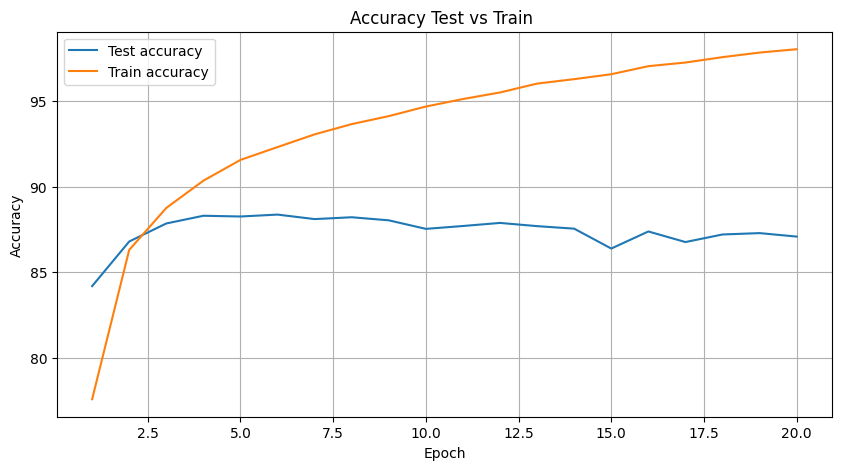

In [ ]:
print_train_results(train_results,'accuracy')

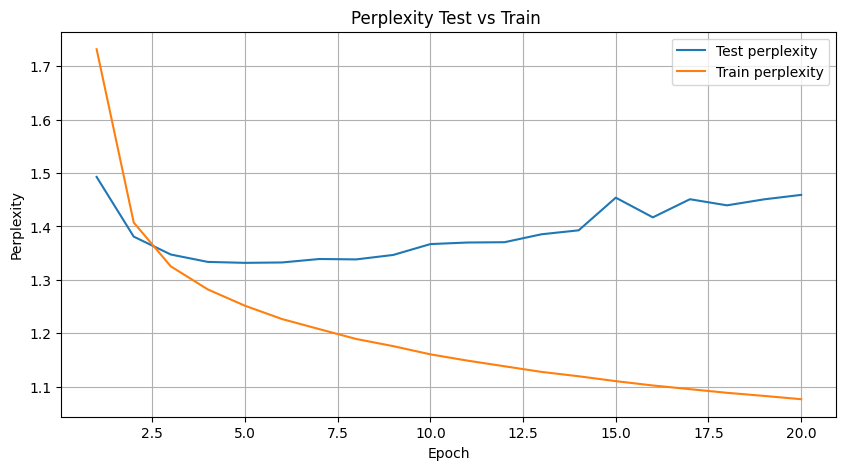

In [ ]:
print_train_results(train_results,'perplexity')

Experimentando o código com o modelo que gera 2 classes (para validação do código e vizualização do overfitting nesse caso também). Com 'verbose=False" para não imprimir os valores durante o treinamento.

In [ ]:

model = OneHotMLPClasses(vocab_size,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_results = train_model(model, criterion, optimizer, 20, train_loader, test_loader, verbose=False)


A Loss inicial de cross entropy 0.6912642121315002 está correta! Diferença de 0.0018 (arredondamentos)


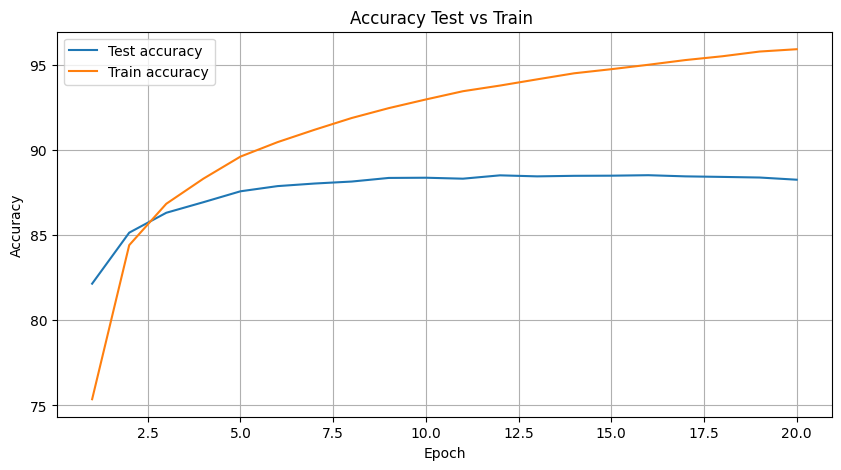

In [ ]:
print_train_results(train_results,'accuracy')

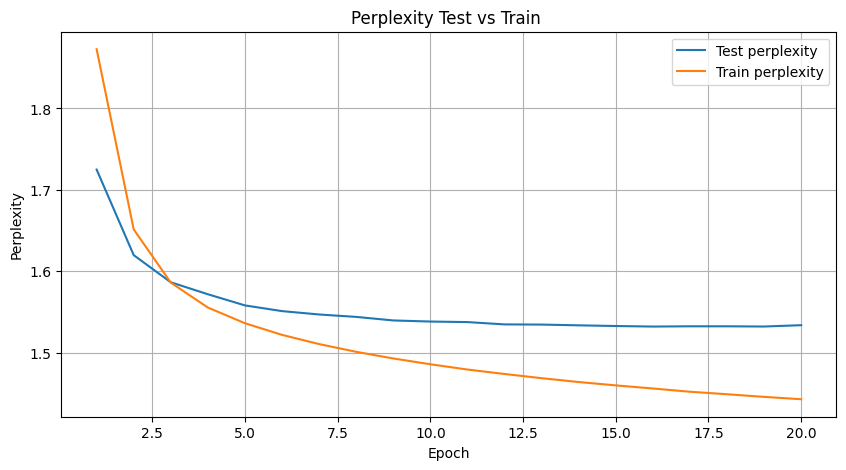

In [ ]:
print_train_results(train_results,'perplexity')

**Visualizando o overfit**

Uma forma de validar o modelo é ver se ele está diminuindo a loss para um batch apenas.
Se considerarmos como teste todos os dados, o overfit será logo percebido.


In [ ]:
def create_dataloader_getting_records(data_loader, num_records):
    """
    Retorna um novo DataLoader que contém apenas os primeiros num_records de data_loader.dataset
    """
    # Cria um subconjunto do conjunto de dados original
    subset = Subset(data_loader.dataset, indices=range(num_records))

    # Cria um novo DataLoader a partir do subconjunto
    new_data_loader = DataLoader(subset, batch_size=data_loader.batch_size, shuffle=False)

    return new_data_loader


In [ ]:
train_loader_1000 = create_dataloader_getting_records(train_loader,1000)

In [ ]:
print(f'train_loader_1000 tem {len(train_loader_1000)} batches e {len(train_loader_1000.dataset)} records')

train_loader_1000 tem 63 batches e 1000 records


In [ ]:
model = OneHotMLPClasses(vocab_size,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_results = train_model(model, criterion, optimizer, 10, train_loader_1000, test_loader, verbose=True)


A Loss inicial de cross entropy 0.6932174563407898 está correta! Diferença de 0.0001 (arredondamentos)
Dimensões dos outputs: torch.Size([16, 2])
Dimensões dos labels: torch.Size([16])
Epoch [1/10], train loss: 0.4418, train accuracy: 98.5000, train perplexity: 1.7234, test accuracy: 50.0000, test perplexity: 2.0923, Elapsed Time: 0.11 sec
Epoch [2/10], train loss: 0.3635, train accuracy: 100.0000, train perplexity: 1.4644, test accuracy: 50.0000, test perplexity: 2.1747, Elapsed Time: 0.11 sec
Epoch [3/10], train loss: 0.3410, train accuracy: 100.0000, train perplexity: 1.4110, test accuracy: 50.0000, test perplexity: 2.2057, Elapsed Time: 0.11 sec
Epoch [4/10], train loss: 0.3315, train accuracy: 100.0000, train perplexity: 1.3940, test accuracy: 50.0000, test perplexity: 2.2203, Elapsed Time: 0.11 sec
Epoch [5/10], train loss: 0.3265, train accuracy: 100.0000, train perplexity: 1.3863, test accuracy: 50.0000, test perplexity: 2.2286, Elapsed Time: 0.11 sec
Epoch [6/10], train loss: 

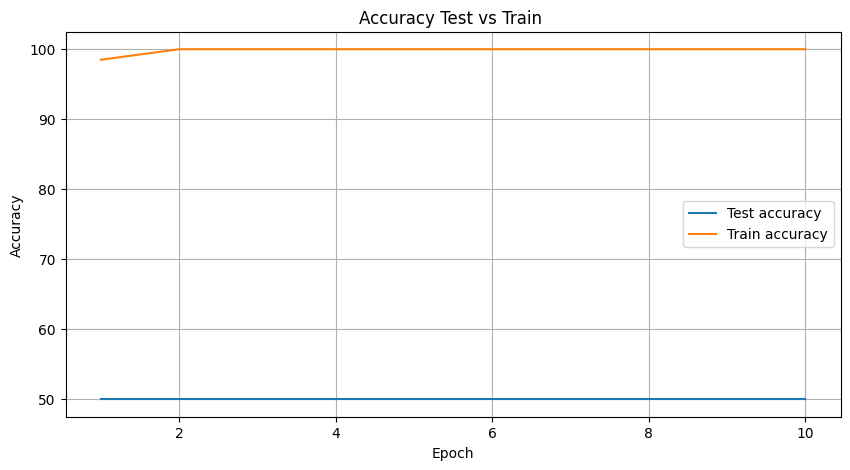

In [ ]:
print_train_results(train_results,'accuracy')

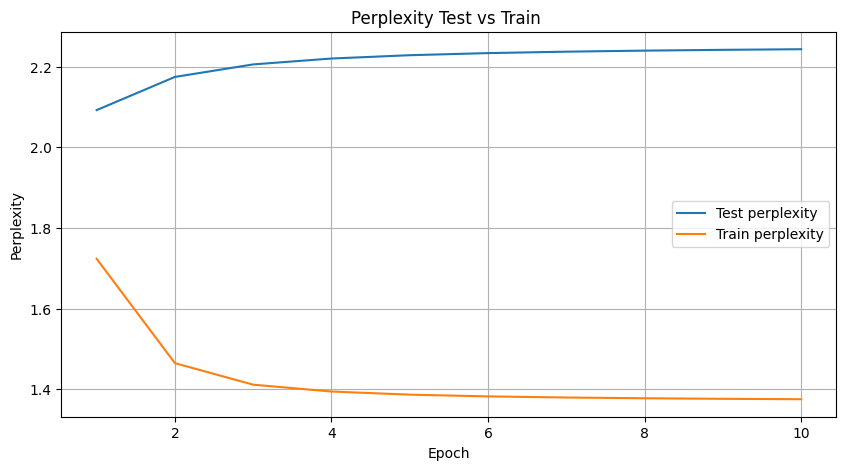

In [ ]:
print_train_results(train_results,'perplexity')

Pelos gráficos, percebe-se que o modelo está aprendendo (métricas melhoram nos dados de treinamento), mas está "overfitando". Ele está como que se especializando nos dados de treinamento. E como os dados de teste são genéricos, ele não alcança bons reultados em teste.

## **Comentários finais:**
Se você conseguiu chegar até aqui, fazendo todos os exercícios, parabéns. Espero que você tenha aprendido vários conceitos importantes de treinamento de redes neurais. O valioso é que tudo o que foi visto aqui é válido tanto para modelos de alguns milhares de parâmetros como visto aqui até os modelos LLM da ordem de bilhões de parâmetros.
Dominar técnicas de treinamento de modelos deep learning é possível apenas com muita experiência de programação e conceitos sólidos da teoria, que não é muita. É a teoria de minimização de funções pelo método do gradiente descendente. Ficou faltando entender como o gradiente é calculado, que é algo que o pytorch e outros ambientes similares conseguiram simplificar e deixá-lo quase imperceptível para o programador.
Espero que você tenha aprendido com esses exercícios. Eles são uma amostra do que estudaremos e da forma como estudaremos no curso IA-024.
Existem vários conceitos muito importantes que não tratamos aqui. Conceito de embedding,
Nesse curso não aceitamos alunos ouvintes, apenas alunos comprometidos com os exercícios e o aprendizado colaborativo com os colegas. Assim, a participação de todos será fundamental para o sucesso do curso.

Formas da Entrega

Os exercícios devem ser entregues em arquivo PDF junto com um notebook com a versão final do código, comentada e com um desempenho bem melhor, ainda utilizando a mesma técnica (BagOfWords) e rede neural de 2 camadas e mesmo número de neurônios.

Os links do arquivo PDF e do Google colab notebook deve ser entregues neste formulário: https://forms.gle/xAGtt55fYpHW23eZA  
Entregue a versão final do Google colab, contendo as modificações sugeridas ao longo dos exercícios que você conseguiu fazer.

Avaliação:

Esse é um processo seletivo para escolher alunos especiais para o curso IA-024 onde existem 50 candidatos inscritos. Serão selecionados os alunos que obtiverem as melhores avaliações nas respostas dos exercícios. É esperado que sejam selecionados da ordem de 10 a 15 alunos especiais.



